<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_with_latent_subspaces_categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoder Model (VAE) with latent subspaces based on:
https://arxiv.org/pdf/1812.06190.pdf

In [1]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

Using TensorFlow backend.


In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, U = make_blobs(n_samples=500, centers=5, n_features=20,random_state=0)

In [0]:
t = np.random.uniform(0.0, 1.0, 500)
u = np.random.uniform(0.0, 1.0, 500)
s = np.random.uniform(0.0, 1.0, 500)

In [0]:
X1 = 10.0*np.cos(t)[:,np.newaxis]
X2 = 10.0*np.sin(t)[:,np.newaxis]
X3 = 10.0*(0.5*t)[:,np.newaxis]

# X4 = u[:,np.newaxis]
# X5 = (u*u)[:,np.newaxis]
# X6 = np.sin(0.5*u)[:,np.newaxis]

# X7 = (s*s*s)[:,np.newaxis]
# X8 = (s+0.2)[:,np.newaxis]
# X9 = 3.2*np.cos(0.5*s)[:,np.newaxis]

In [0]:
# X = np.concatenate((X, X1, X2, X3, X4, X5, X6, X7, X8, X9), axis=-1) #data
X = np.concatenate((X, X1, X2, X3), axis=-1) #data

In [103]:
X.shape

(500, 23)

In [0]:
#Reconstruction loss
def x_given_w_z(w, z, output_size, training_phase, reg):
  with tf.variable_scope('M/x_given_w_z'):
    act = tf.nn.leaky_relu
    
    h = tf.concat((w,z), axis=-1)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    h = tf.layers.batch_normalization(h, training=training_phase)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.batch_normalization(h, training=training_phase)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.batch_normalization(h, training=training_phase)
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    loc = tf.layers.dense(h, output_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for w
def w_given_x_y(x, y, latent_size, training_phase, reg): #+
  with tf.variable_scope('M/w_given_x_y'):
    act = tf.nn.leaky_relu
    h = tf.concat((x,y), axis=-1)
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

# def w_given_y(y, y_size, training_phase, reg):
#   with tf.variable_scope('M/w_given_y'):
#     act = tf.nn.leaky_relu
#     h = y
    
#     h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
#     loc = tf.layers.dense(h, y_size)
#     log_variance = tf.layers.dense(h, y_size)
#     scale = tf.nn.softplus(log_variance)
#     return tfd.MultivariateNormalDiag(loc, scale)

def w_given_y(y, y_size, training_phase, reg):
  with tf.variable_scope('M/w_given_y'):
    act = tf.nn.leaky_relu
    h = y
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    return tfd.MultivariateNormalDiag(loc, scale)
  
  
  
#KL term for z
def z_given_x(x, latent_size, training_phase, reg): #+
  with tf.variable_scope('M/z_given_x'):
    act = tf.nn.leaky_relu
    h = x
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
#     scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def z_given(latent_size):
  with tf.variable_scope('M/z_given'):
    loc = tf.zeros(latent_size)
    scale = 0.1*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


# #For the Mutual information term
# def y_given_z(z, y_size, training_phase, reg, reuse=None):
#   with tf.variable_scope('N', reuse=reuse):
#     act = tf.nn.leaky_relu
#     h = z
    
#     h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
#     h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    
    
#     loc = tf.layers.dense(h, y_size)
#     log_variance = tf.layers.dense(h, y_size)
#     scale = tf.nn.softplus(log_variance)
#     #scale = 0.01*tf.ones(tf.shape(loc))
#     return tfd.MultivariateNormalDiag(loc, scale)
  
  
def y_given_z(z, y_size, training_phase, reg, reuse=None):
  with tf.variable_scope('N', reuse=reuse):
    act = tf.nn.leaky_relu
    h = z
    
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    
    
    loc = tf.layers.dense(h, y_size)
    loc = tf.nn.softmax(loc, axis=-1)
    return tfd.Categorical(probs=loc)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.int32, shape=[None, 1], name='u_in')
training_phase = tf.placeholder(tf.bool, None, name='training_phase')
reg = regularizers.l1_l2(l1=0.0, l2=0.0000001)

beta = np.array([20.0, 0.1, 0.001, 10.0, 1.0])
#beta= np.array([100000.0, 1.0, 0.02, 10.0, 1.0])
y_size = 5 

z_latent_size = 2
w_latent_size = 2

M_learning_rate = 5e-4
N_learning_rate = 5e-4

u_one_hot = tf.one_hot(u_in[:,0], y_size, axis=-1)

#KL_w
wIy = w_given_y(u_one_hot, w_latent_size, training_phase, reg)
wIxy = w_given_x_y(x_in, u_one_hot, w_latent_size, training_phase, reg)
wIxy_sample = wIxy.sample()
wIxy_mean = wIxy.mean()
kl_w = tf.reduce_mean(wIxy.log_prob(wIxy_sample)- wIy.log_prob(wIxy_sample))
#kl_w = tf.reduce_mean(tfd.kl_divergence(wIxy, wIy)) #analytical

#KL_z
zI = z_given(z_latent_size)
zIx = z_given_x(x_in, z_latent_size, training_phase, reg)
zIx_sample = zIx.sample()
zIx_mean = zIx.mean()
kl_z = tf.reduce_mean(zIx.log_prob(zIx_sample)- zI.log_prob(zIx_sample))
#kl_z = tf.reduce_mean(tfd.kl_divergence(zIx, zI)) #analytical

#Reconstruction
xIwz = x_given_w_z(wIxy_sample, zIx_sample, X.shape[1], training_phase, reg)
rec_out = xIwz.mean()
rec_loss = tf.losses.mean_squared_error(x_out, rec_out)

M1 = beta[0]*rec_loss + beta[1]*kl_w + beta[2]*kl_z

yIz = y_given_z(zIx_sample, y_size, training_phase, reg, reuse=False)
ent2 = -tf.reduce_mean(yIz.entropy())
M2 = beta[3]*ent2

M_reg = tf.losses.get_regularization_loss(scope='M/')

M_cost = M1 + M2 + M_reg

M_optimizer = tf.train.AdamOptimizer(M_learning_rate)

M_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='M/')
M_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='M/')

with tf.control_dependencies(M_update_ops):
  M_train = M_optimizer.minimize(M_cost, var_list=M_train_vars,
                                       name='train_M')

  
yIz_N = y_given_z(zIx_sample, y_size, training_phase, reg, reuse=True)
#logN = tf.reduce_mean(-yIz_N.log_prob(u_in))
logN = -tf.reduce_sum(yIz_N.log_prob(u_in[:,0]))
N = beta[4]*logN

N_reg = tf.losses.get_regularization_loss(scope='N')

N_cost = N + N_reg



N_optimizer = tf.train.AdamOptimizer(N_learning_rate)

N_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='N')
N_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='N')

with tf.control_dependencies(N_update_ops):
  N_train = N_optimizer.minimize(N_cost, var_list=N_train_vars,
                                       name='train_N')

# Saver to save session for reuse
saver = tf.train.Saver()

In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

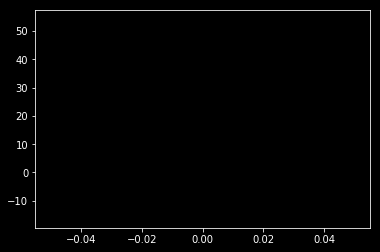

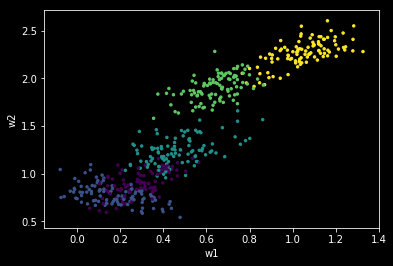

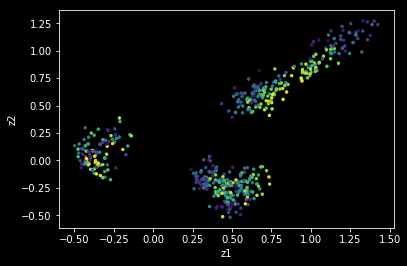

epoch: 1, M_loss: 352.3, M1_loss: 360.3, M2_loss: -8.0, N_loss: 403.24
epoch: 1, rec_loss: 17.99494, kl_w: 1.50, kl_z: 269.19


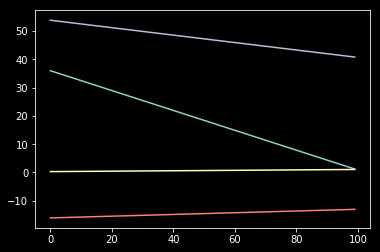

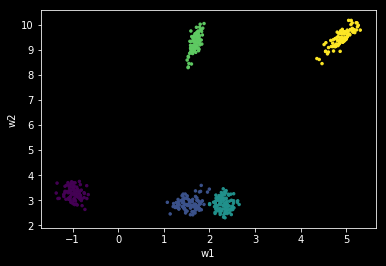

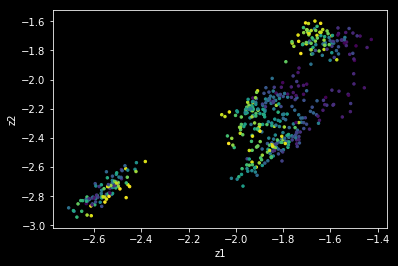

epoch: 100, M_loss: 6.3, M1_loss: 12.8, M2_loss: -6.5, N_loss: 263.18
epoch: 100, rec_loss: 0.60296, kl_w: 5.27, kl_z: 204.07


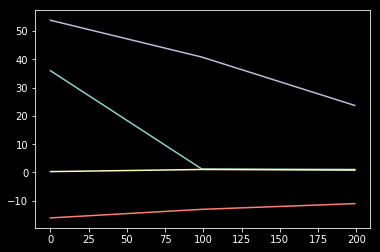

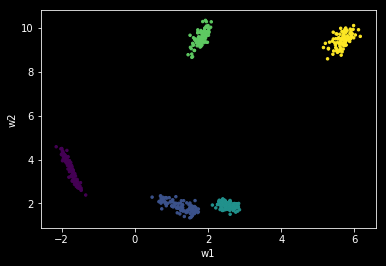

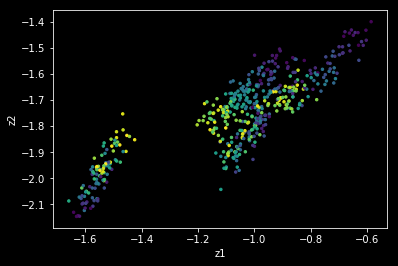

epoch: 200, M_loss: 5.6, M1_loss: 11.1, M2_loss: -5.5, N_loss: 253.35
epoch: 200, rec_loss: 0.53047, kl_w: 4.19, kl_z: 118.52


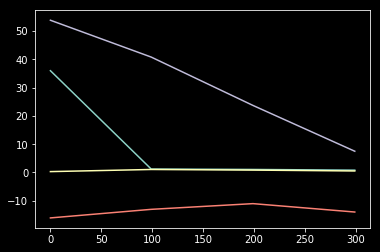

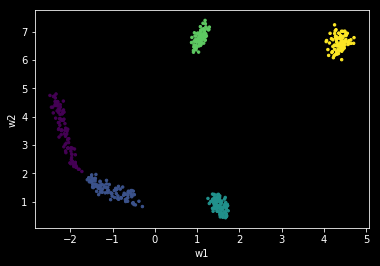

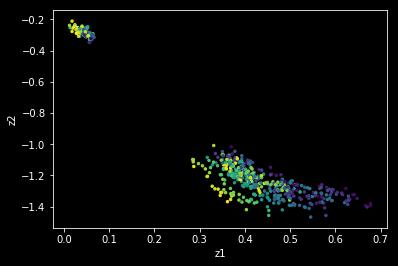

epoch: 300, M_loss: 1.5, M1_loss: 8.5, M2_loss: -7.0, N_loss: 359.73
epoch: 300, rec_loss: 0.40849, kl_w: 2.63, kl_z: 37.53


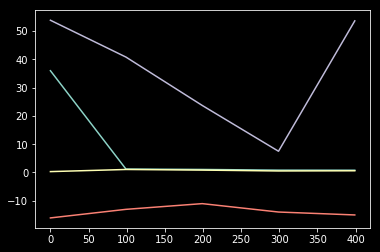

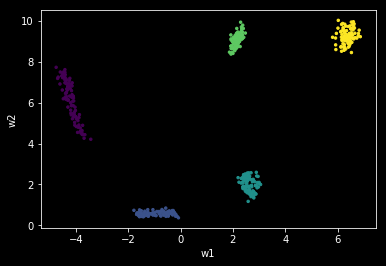

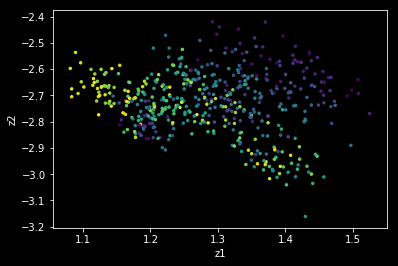

epoch: 400, M_loss: 1.0, M1_loss: 8.5, M2_loss: -7.5, N_loss: 372.31
epoch: 400, rec_loss: 0.39717, kl_w: 2.98, kl_z: 268.09


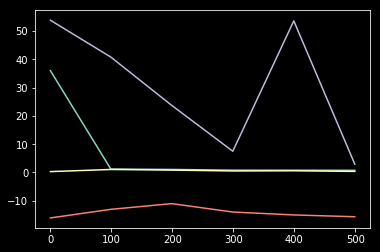

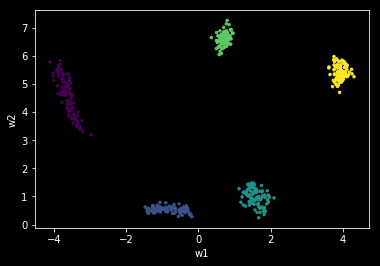

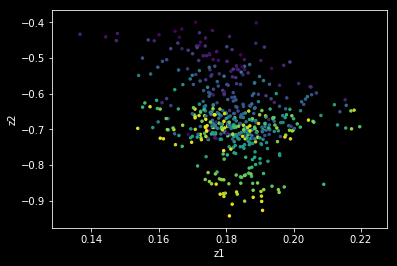

epoch: 500, M_loss: -0.0, M1_loss: 7.8, M2_loss: -7.8, N_loss: 395.54
epoch: 500, rec_loss: 0.38025, kl_w: 1.90, kl_z: 14.67


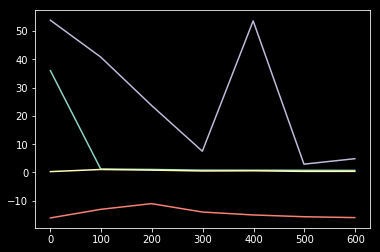

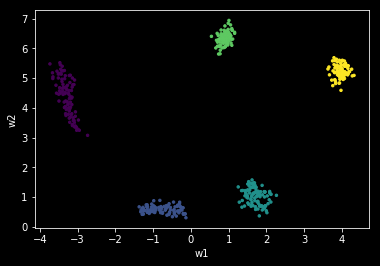

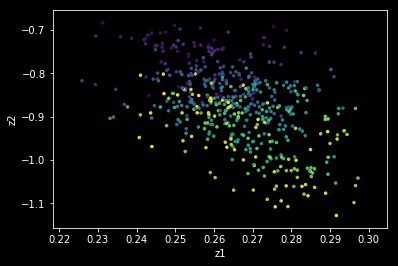

epoch: 600, M_loss: -0.4, M1_loss: 7.6, M2_loss: -8.0, N_loss: 401.98
epoch: 600, rec_loss: 0.36686, kl_w: 1.96, kl_z: 24.32


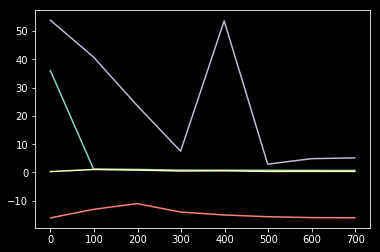

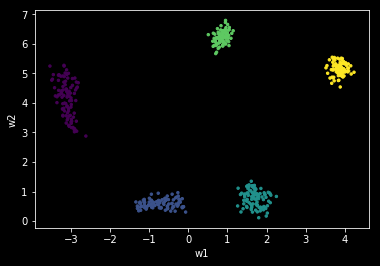

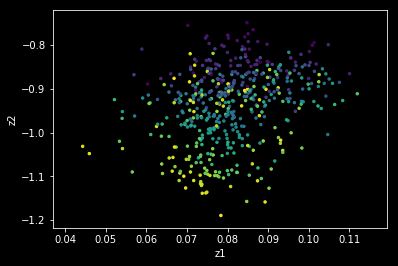

epoch: 700, M_loss: -0.7, M1_loss: 7.4, M2_loss: -8.0, N_loss: 404.27
epoch: 700, rec_loss: 0.35678, kl_w: 1.93, kl_z: 25.86


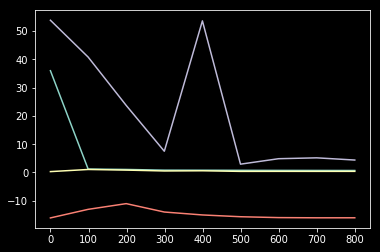

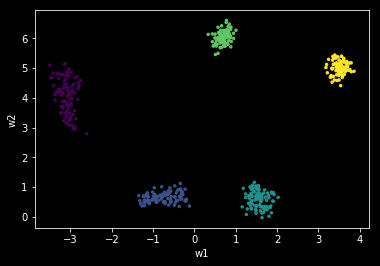

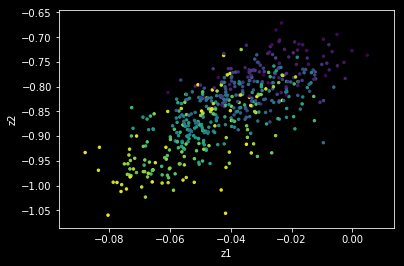

epoch: 800, M_loss: -0.8, M1_loss: 7.2, M2_loss: -8.0, N_loss: 397.54
epoch: 800, rec_loss: 0.34941, kl_w: 1.96, kl_z: 21.95


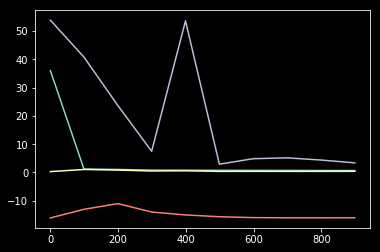

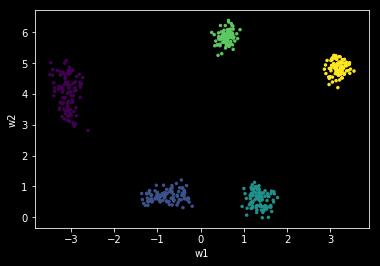

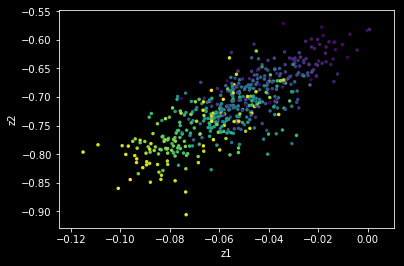

epoch: 900, M_loss: -1.0, M1_loss: 7.0, M2_loss: -8.0, N_loss: 400.95
epoch: 900, rec_loss: 0.34123, kl_w: 2.00, kl_z: 16.98


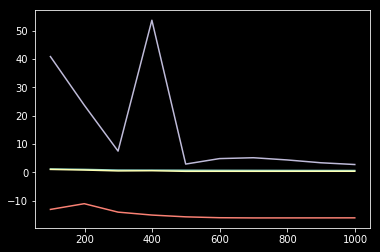

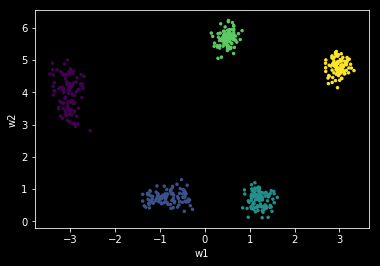

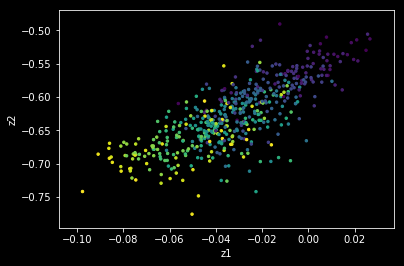

epoch: 1000, M_loss: -1.1, M1_loss: 6.9, M2_loss: -8.0, N_loss: 399.60
epoch: 1000, rec_loss: 0.33537, kl_w: 2.01, kl_z: 13.88


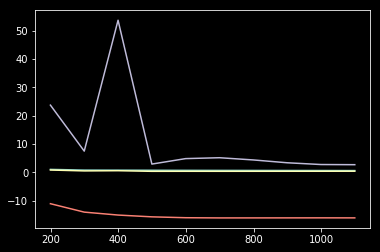

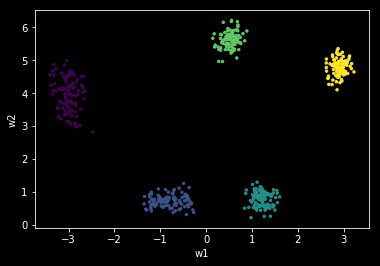

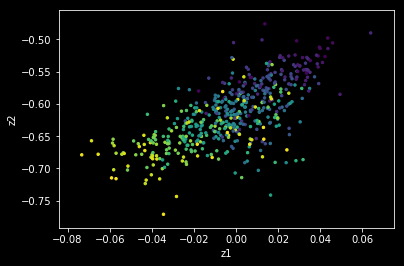

epoch: 1100, M_loss: -1.3, M1_loss: 6.7, M2_loss: -8.0, N_loss: 402.93
epoch: 1100, rec_loss: 0.32348, kl_w: 2.11, kl_z: 13.59


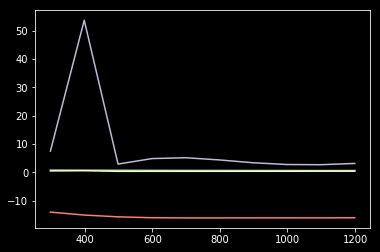

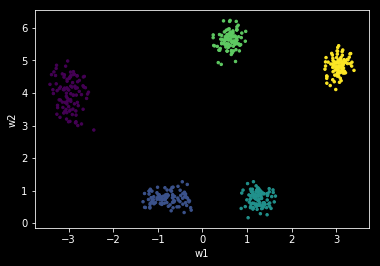

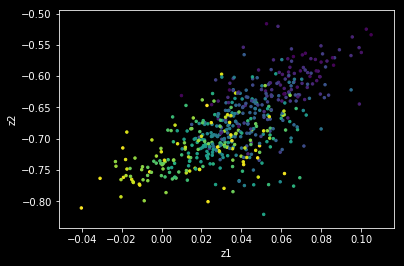

epoch: 1200, M_loss: -1.0, M1_loss: 7.0, M2_loss: -8.0, N_loss: 392.68
epoch: 1200, rec_loss: 0.33600, kl_w: 2.15, kl_z: 15.79


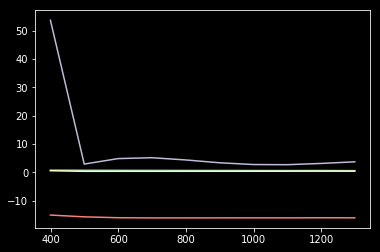

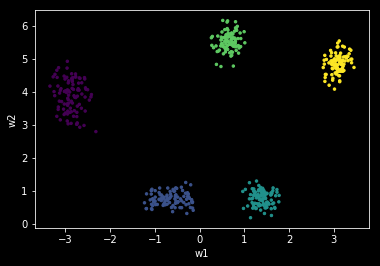

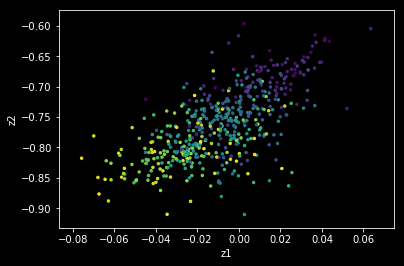

epoch: 1300, M_loss: -1.6, M1_loss: 6.4, M2_loss: -8.0, N_loss: 397.27
epoch: 1300, rec_loss: 0.30853, kl_w: 2.18, kl_z: 18.66


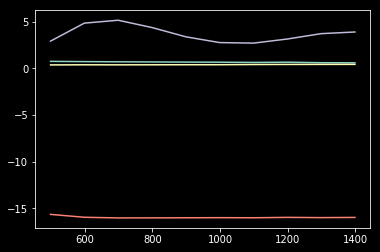

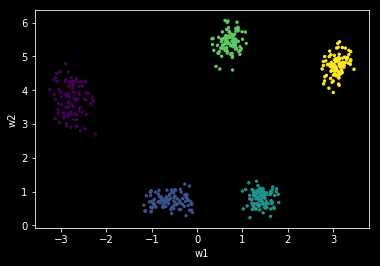

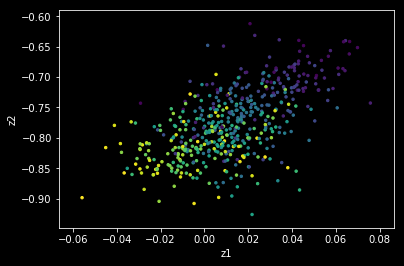

epoch: 1400, M_loss: -1.7, M1_loss: 6.3, M2_loss: -8.0, N_loss: 395.37
epoch: 1400, rec_loss: 0.30280, kl_w: 2.19, kl_z: 19.56


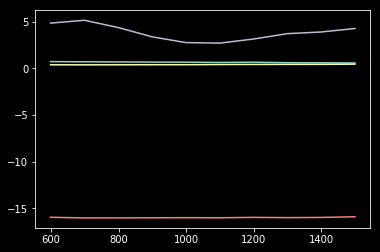

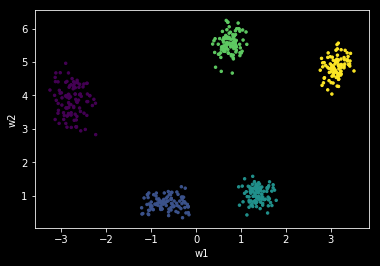

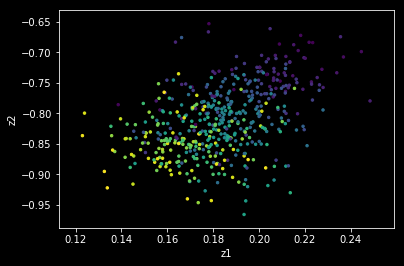

epoch: 1500, M_loss: -1.8, M1_loss: 6.1, M2_loss: -8.0, N_loss: 392.47
epoch: 1500, rec_loss: 0.29313, kl_w: 2.32, kl_z: 21.44


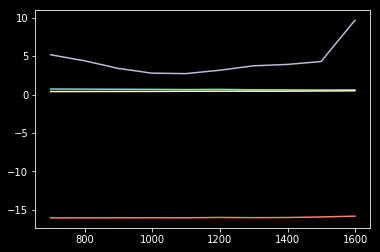

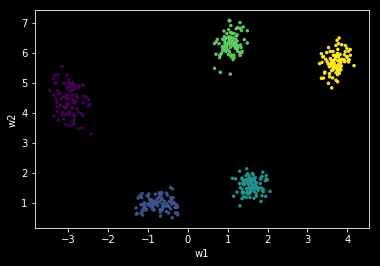

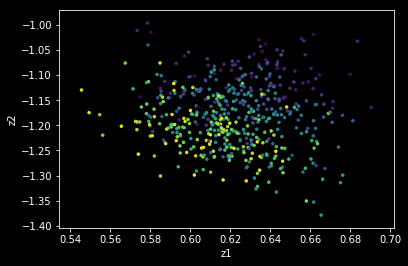

epoch: 1600, M_loss: -1.6, M1_loss: 6.3, M2_loss: -7.9, N_loss: 382.11
epoch: 1600, rec_loss: 0.30048, kl_w: 2.42, kl_z: 48.28


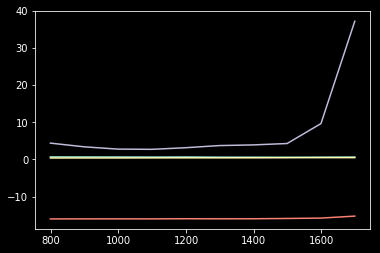

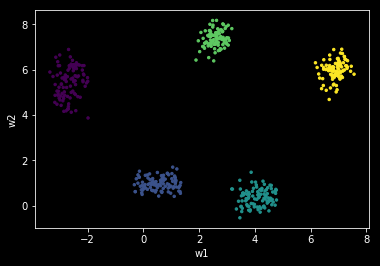

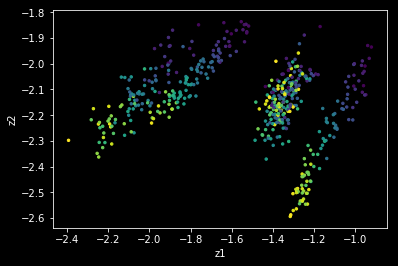

epoch: 1700, M_loss: -0.8, M1_loss: 6.9, M2_loss: -7.6, N_loss: 402.59
epoch: 1700, rec_loss: 0.32264, kl_w: 2.42, kl_z: 186.17


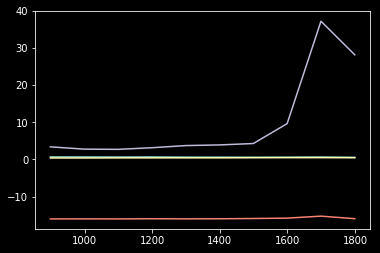

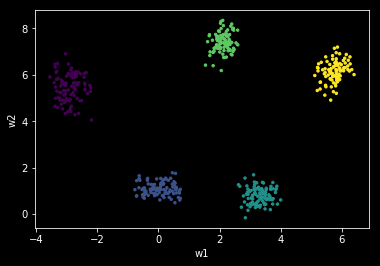

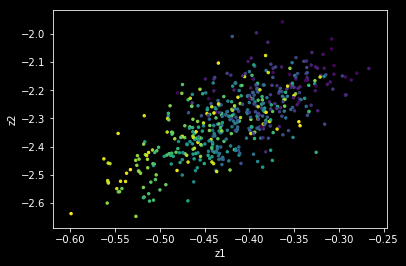

epoch: 1800, M_loss: -1.9, M1_loss: 6.0, M2_loss: -8.0, N_loss: 392.69
epoch: 1800, rec_loss: 0.28303, kl_w: 2.31, kl_z: 140.96


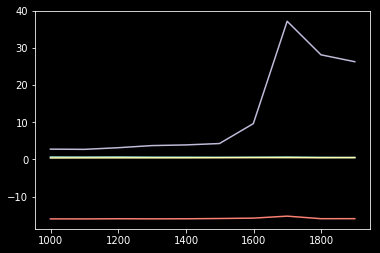

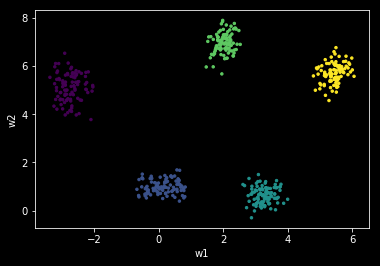

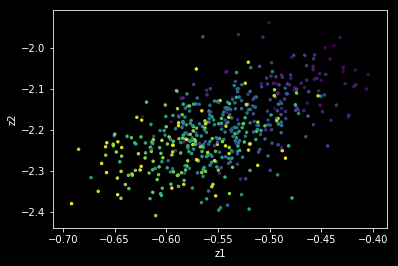

epoch: 1900, M_loss: -2.3, M1_loss: 5.7, M2_loss: -8.0, N_loss: 394.45
epoch: 1900, rec_loss: 0.26734, kl_w: 2.44, kl_z: 131.66


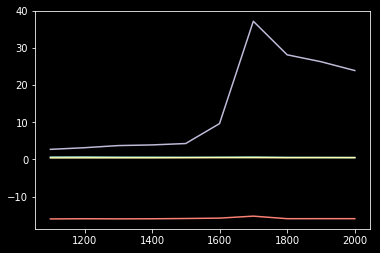

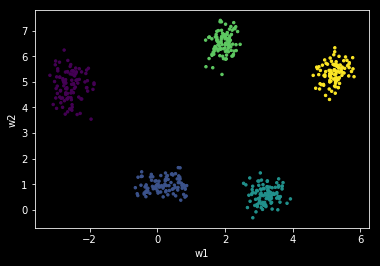

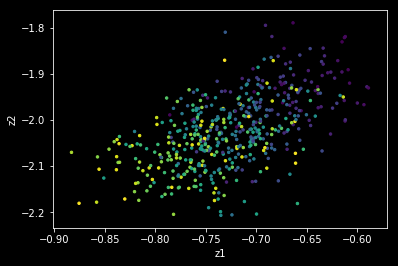

epoch: 2000, M_loss: -2.5, M1_loss: 5.5, M2_loss: -8.0, N_loss: 395.27
epoch: 2000, rec_loss: 0.25666, kl_w: 2.42, kl_z: 119.75


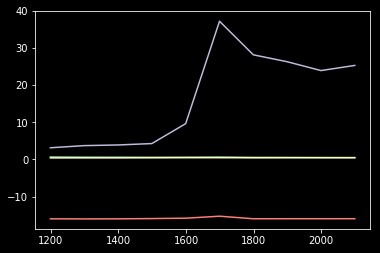

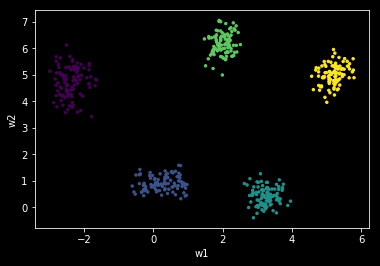

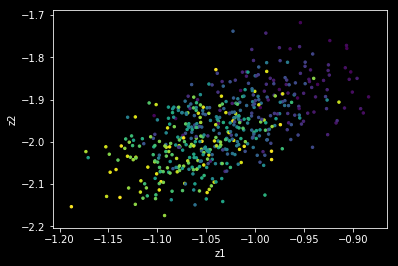

epoch: 2100, M_loss: -2.6, M1_loss: 5.3, M2_loss: -8.0, N_loss: 392.69
epoch: 2100, rec_loss: 0.24842, kl_w: 2.45, kl_z: 126.65


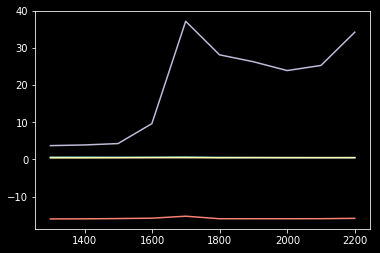

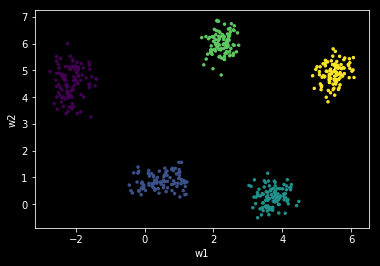

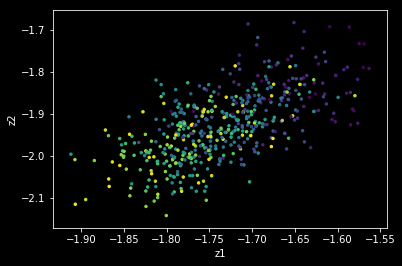

epoch: 2200, M_loss: -2.7, M1_loss: 5.2, M2_loss: -7.9, N_loss: 389.16
epoch: 2200, rec_loss: 0.23978, kl_w: 2.54, kl_z: 171.45


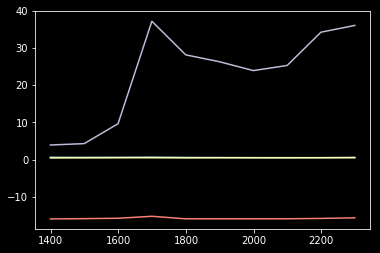

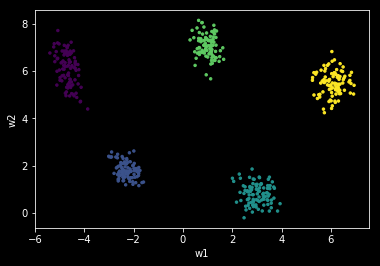

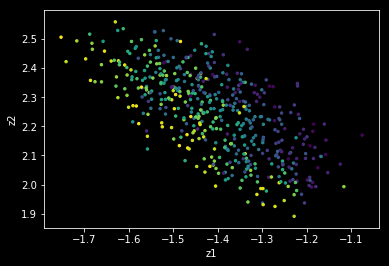

epoch: 2300, M_loss: -1.6, M1_loss: 6.3, M2_loss: -7.8, N_loss: 395.41
epoch: 2300, rec_loss: 0.29239, kl_w: 2.47, kl_z: 180.55


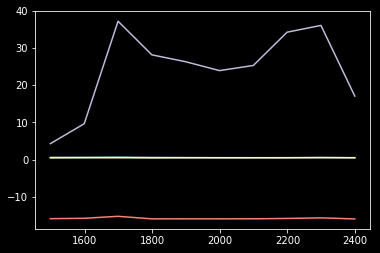

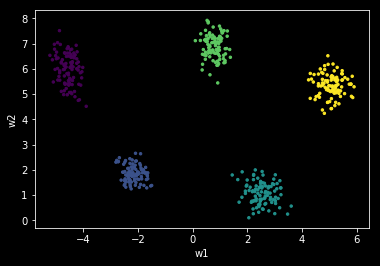

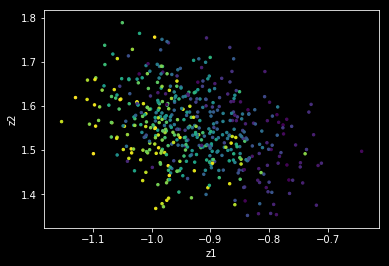

epoch: 2400, M_loss: -2.8, M1_loss: 5.2, M2_loss: -8.0, N_loss: 391.39
epoch: 2400, rec_loss: 0.24471, kl_w: 2.51, kl_z: 85.47


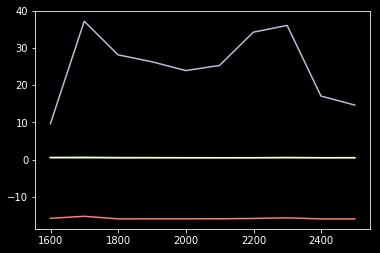

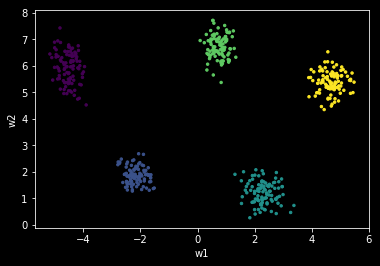

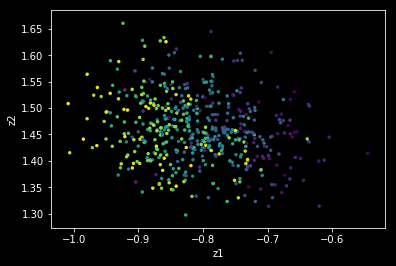

epoch: 2500, M_loss: -3.0, M1_loss: 5.0, M2_loss: -8.0, N_loss: 401.03
epoch: 2500, rec_loss: 0.23442, kl_w: 2.61, kl_z: 73.33


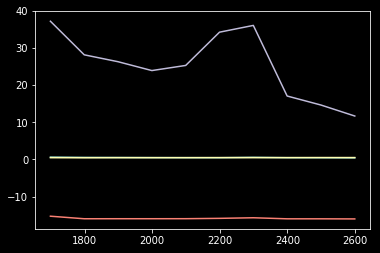

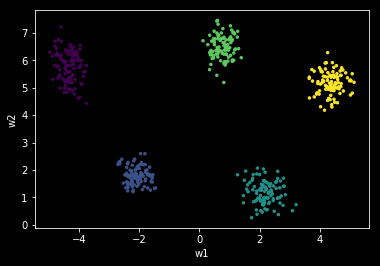

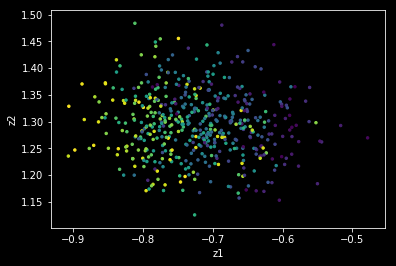

epoch: 2600, M_loss: -3.3, M1_loss: 4.7, M2_loss: -8.0, N_loss: 399.65
epoch: 2600, rec_loss: 0.21991, kl_w: 2.60, kl_z: 58.54


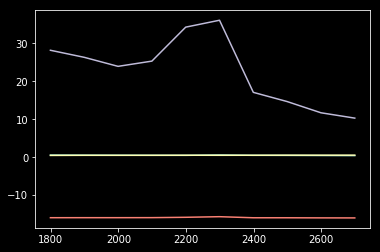

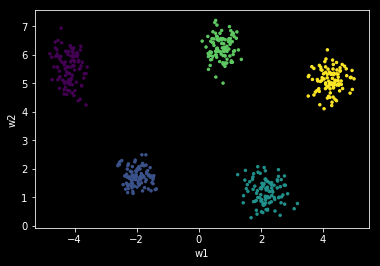

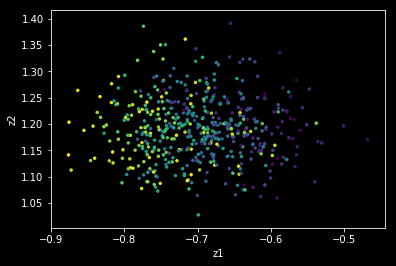

epoch: 2700, M_loss: -3.6, M1_loss: 4.4, M2_loss: -8.0, N_loss: 402.45
epoch: 2700, rec_loss: 0.20512, kl_w: 2.66, kl_z: 51.49


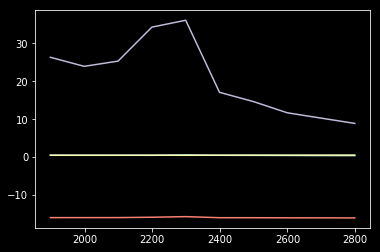

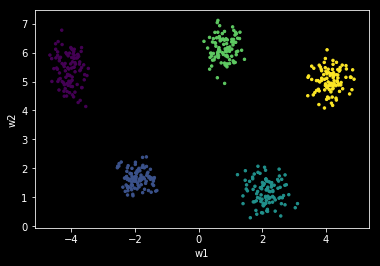

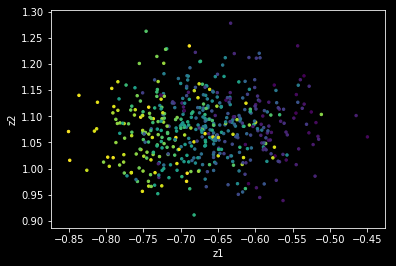

epoch: 2800, M_loss: -3.8, M1_loss: 4.2, M2_loss: -8.0, N_loss: 402.10
epoch: 2800, rec_loss: 0.19556, kl_w: 2.72, kl_z: 44.49


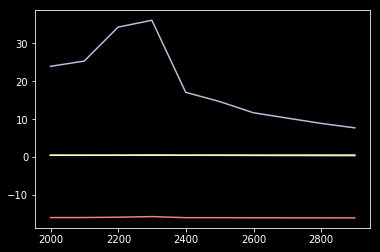

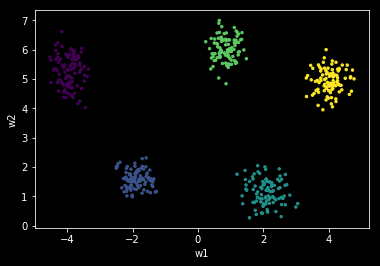

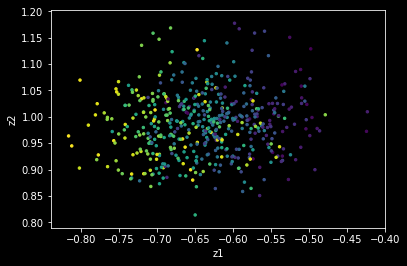

epoch: 2900, M_loss: -3.9, M1_loss: 4.1, M2_loss: -8.0, N_loss: 405.00
epoch: 2900, rec_loss: 0.18939, kl_w: 2.72, kl_z: 38.62


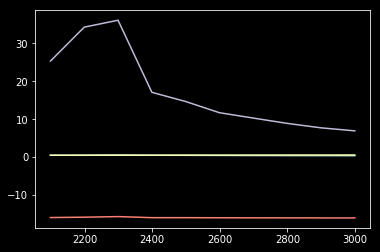

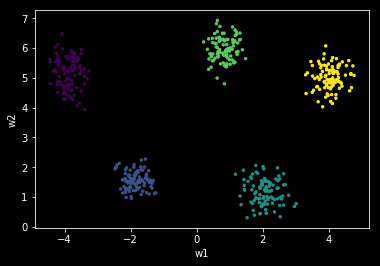

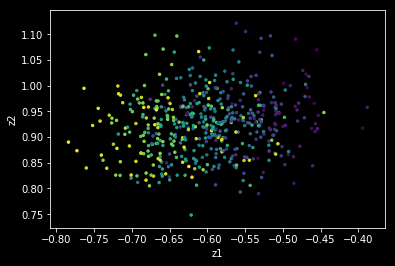

epoch: 3000, M_loss: -4.1, M1_loss: 3.9, M2_loss: -8.0, N_loss: 402.96
epoch: 3000, rec_loss: 0.18100, kl_w: 2.82, kl_z: 34.62


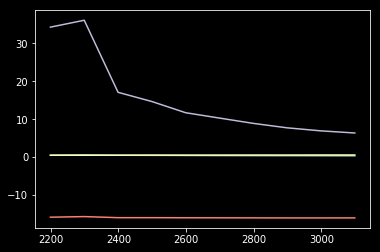

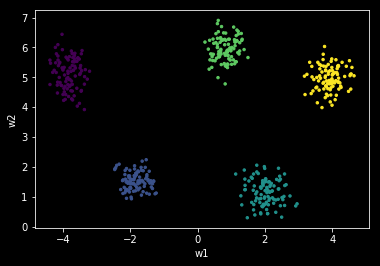

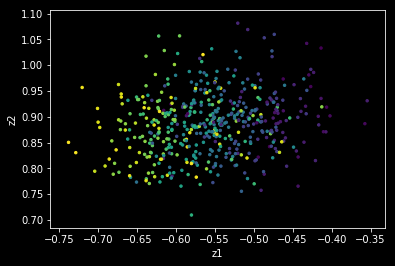

epoch: 3100, M_loss: -4.3, M1_loss: 3.7, M2_loss: -8.0, N_loss: 402.53
epoch: 3100, rec_loss: 0.17186, kl_w: 2.80, kl_z: 31.82


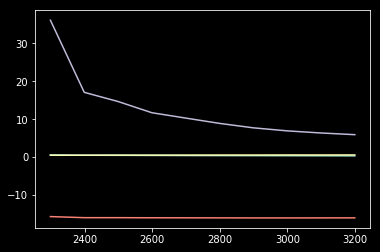

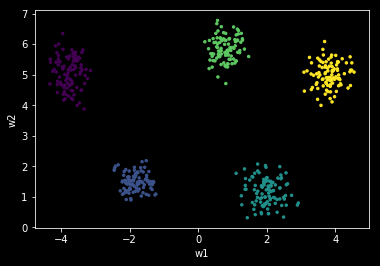

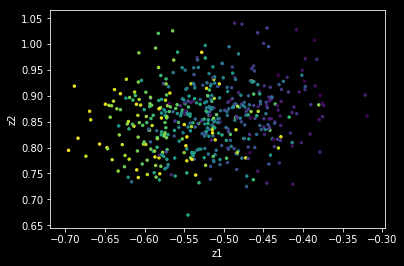

epoch: 3200, M_loss: -4.5, M1_loss: 3.5, M2_loss: -8.0, N_loss: 400.48
epoch: 3200, rec_loss: 0.15961, kl_w: 2.85, kl_z: 29.60


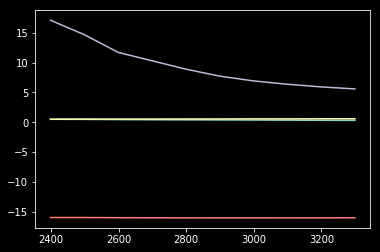

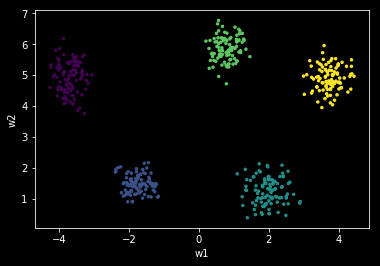

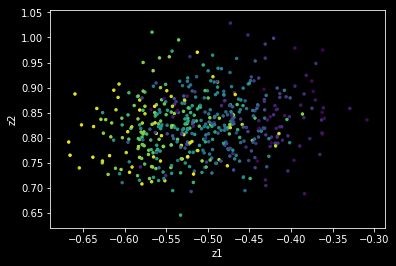

epoch: 3300, M_loss: -4.6, M1_loss: 3.4, M2_loss: -8.0, N_loss: 401.35
epoch: 3300, rec_loss: 0.15227, kl_w: 2.88, kl_z: 27.90


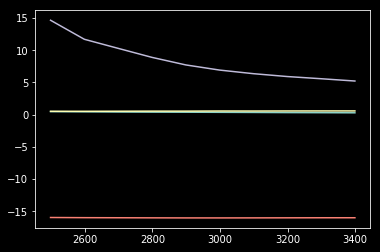

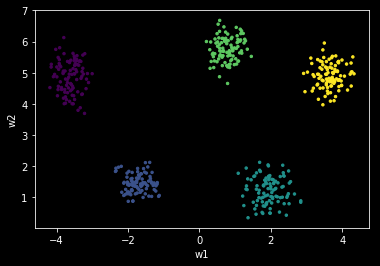

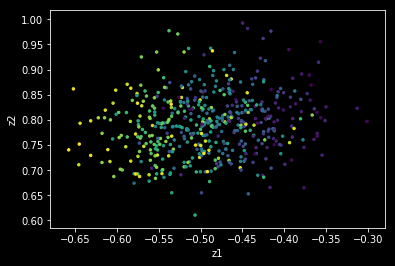

epoch: 3400, M_loss: -4.8, M1_loss: 3.2, M2_loss: -8.0, N_loss: 400.70
epoch: 3400, rec_loss: 0.14371, kl_w: 2.89, kl_z: 26.12


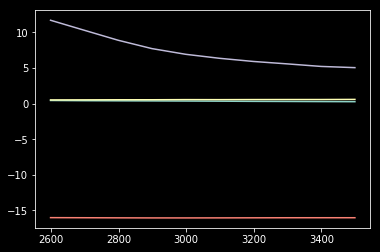

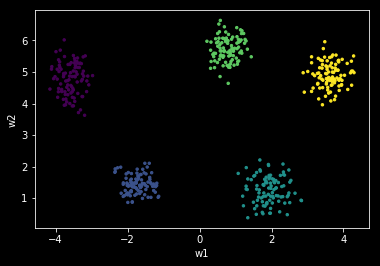

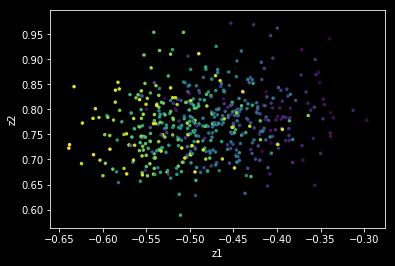

epoch: 3500, M_loss: -5.0, M1_loss: 3.0, M2_loss: -8.0, N_loss: 401.76
epoch: 3500, rec_loss: 0.13635, kl_w: 2.97, kl_z: 25.27


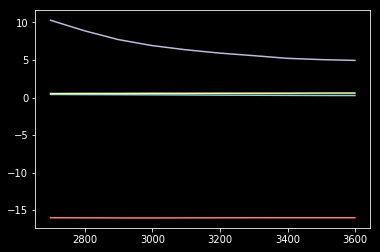

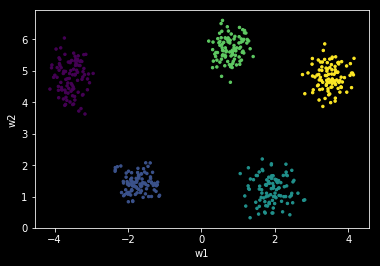

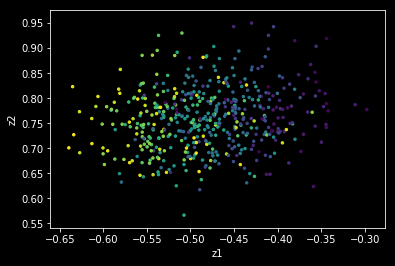

epoch: 3600, M_loss: -5.0, M1_loss: 3.0, M2_loss: -8.0, N_loss: 400.98
epoch: 3600, rec_loss: 0.13364, kl_w: 2.98, kl_z: 24.73


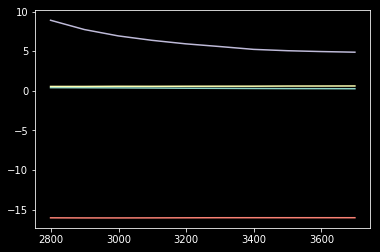

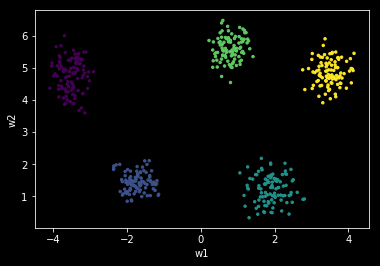

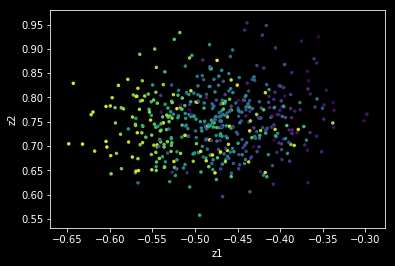

epoch: 3700, M_loss: -5.1, M1_loss: 2.9, M2_loss: -8.0, N_loss: 399.87
epoch: 3700, rec_loss: 0.12809, kl_w: 3.02, kl_z: 24.33


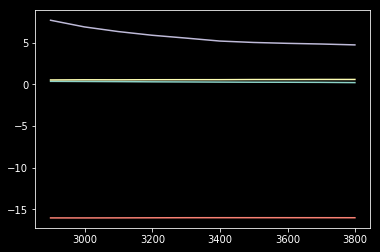

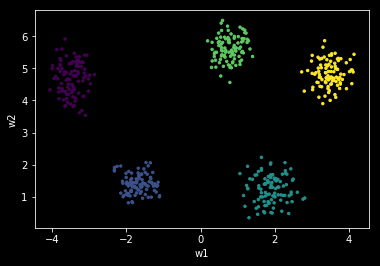

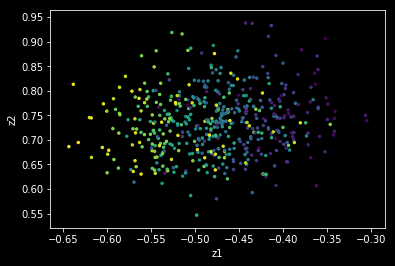

epoch: 3800, M_loss: -5.4, M1_loss: 2.6, M2_loss: -8.0, N_loss: 399.13
epoch: 3800, rec_loss: 0.11246, kl_w: 3.02, kl_z: 23.80


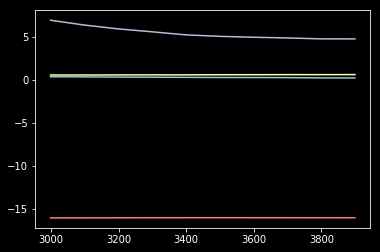

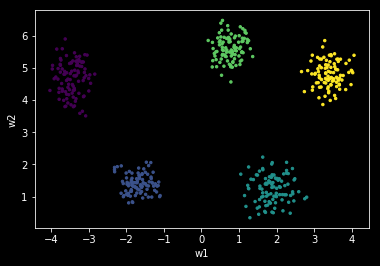

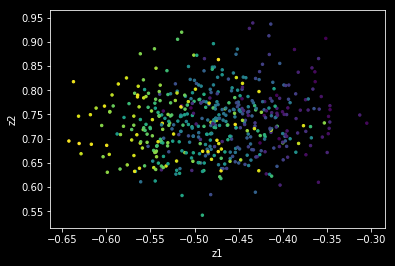

epoch: 3900, M_loss: -5.5, M1_loss: 2.5, M2_loss: -8.0, N_loss: 397.53
epoch: 3900, rec_loss: 0.10907, kl_w: 3.06, kl_z: 23.77


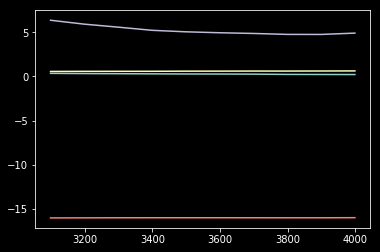

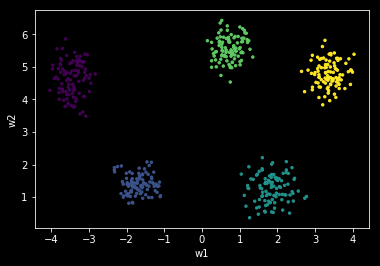

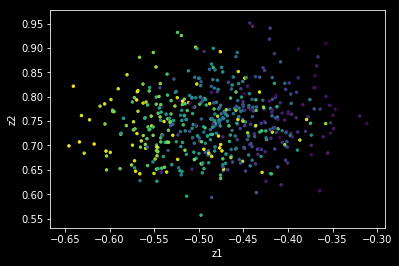

epoch: 4000, M_loss: -5.6, M1_loss: 2.4, M2_loss: -8.0, N_loss: 396.55
epoch: 4000, rec_loss: 0.10533, kl_w: 3.10, kl_z: 24.53


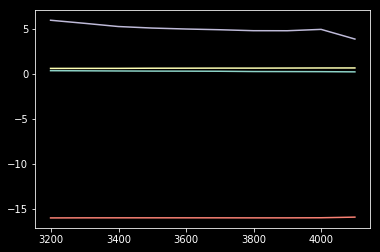

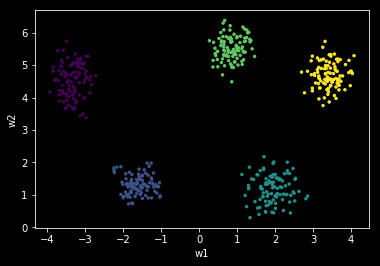

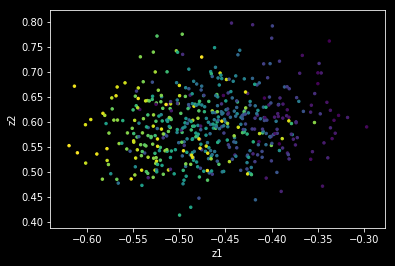

epoch: 4100, M_loss: -5.7, M1_loss: 2.2, M2_loss: -8.0, N_loss: 392.74
epoch: 4100, rec_loss: 0.09469, kl_w: 3.11, kl_z: 19.16


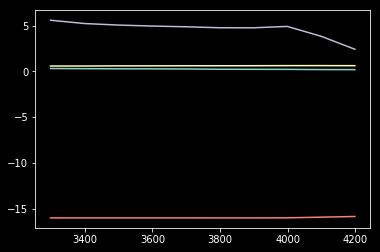

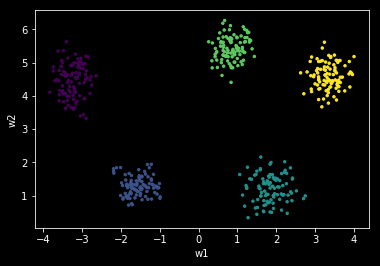

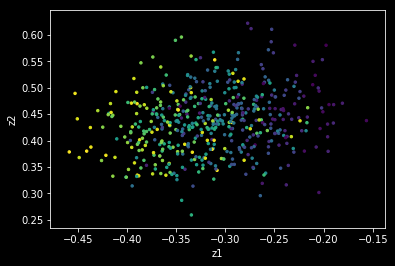

epoch: 4200, M_loss: -5.8, M1_loss: 2.2, M2_loss: -7.9, N_loss: 393.41
epoch: 4200, rec_loss: 0.09171, kl_w: 3.08, kl_z: 12.04


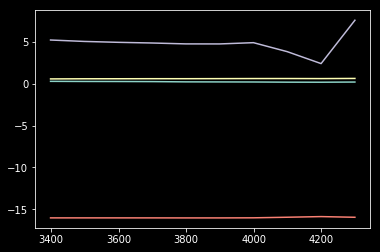

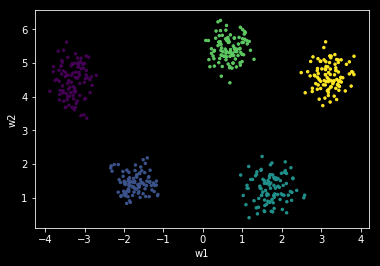

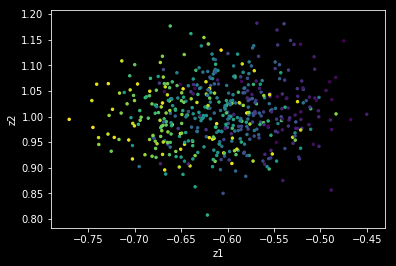

epoch: 4300, M_loss: -5.6, M1_loss: 2.4, M2_loss: -8.0, N_loss: 401.21
epoch: 4300, rec_loss: 0.10224, kl_w: 3.17, kl_z: 37.92


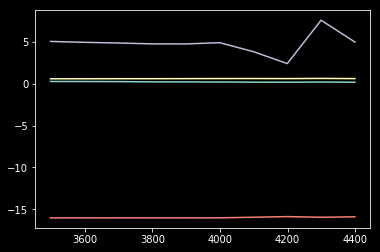

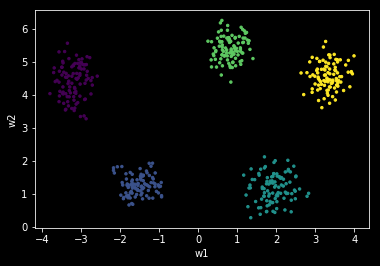

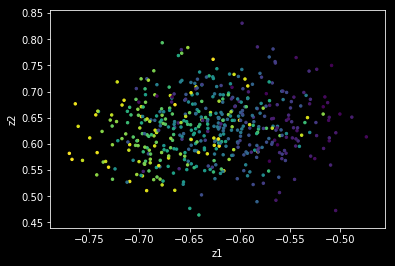

epoch: 4400, M_loss: -5.8, M1_loss: 2.2, M2_loss: -7.9, N_loss: 403.47
epoch: 4400, rec_loss: 0.09089, kl_w: 3.08, kl_z: 24.90


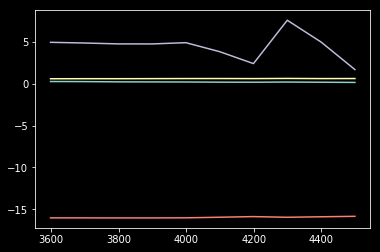

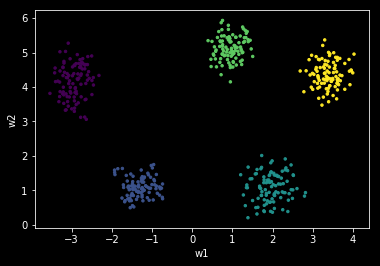

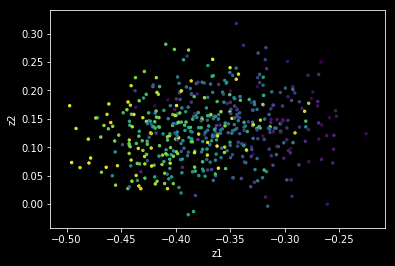

epoch: 4500, M_loss: -6.0, M1_loss: 1.9, M2_loss: -7.9, N_loss: 392.02
epoch: 4500, rec_loss: 0.07924, kl_w: 3.11, kl_z: 8.47


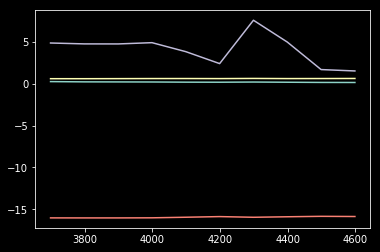

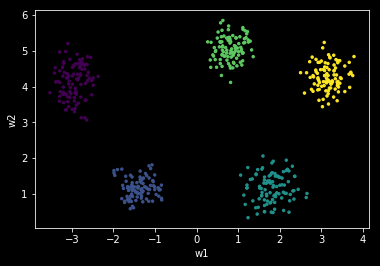

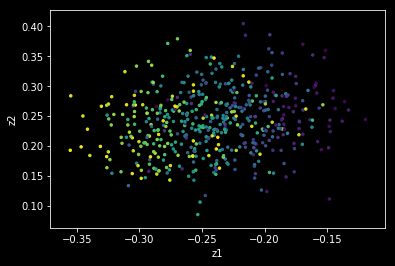

epoch: 4600, M_loss: -6.1, M1_loss: 1.8, M2_loss: -7.9, N_loss: 396.50
epoch: 4600, rec_loss: 0.07562, kl_w: 3.15, kl_z: 7.64


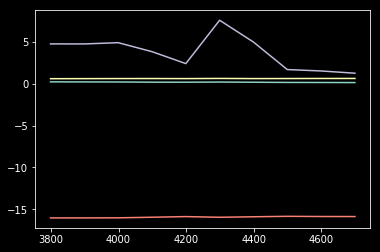

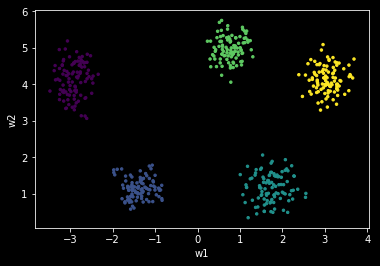

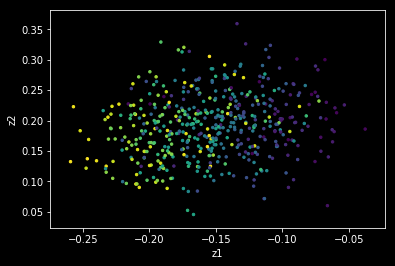

epoch: 4700, M_loss: -6.2, M1_loss: 1.7, M2_loss: -7.9, N_loss: 393.53
epoch: 4700, rec_loss: 0.07023, kl_w: 3.16, kl_z: 6.29


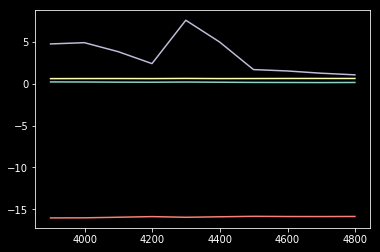

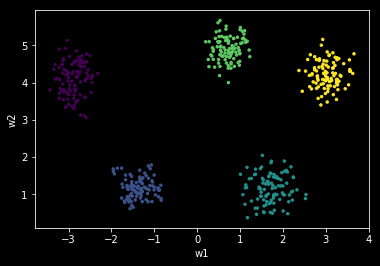

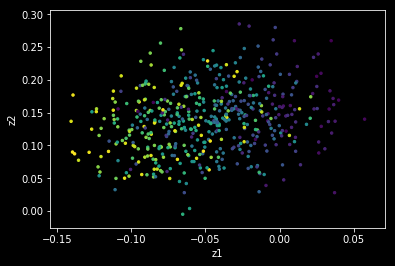

epoch: 4800, M_loss: -6.1, M1_loss: 1.9, M2_loss: -7.9, N_loss: 395.72
epoch: 4800, rec_loss: 0.07662, kl_w: 3.15, kl_z: 5.32


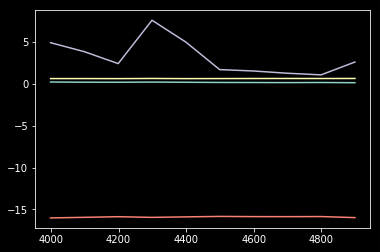

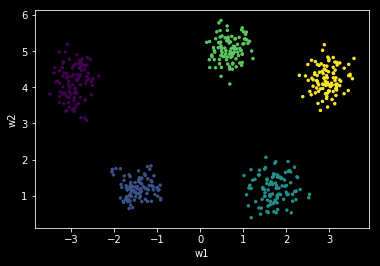

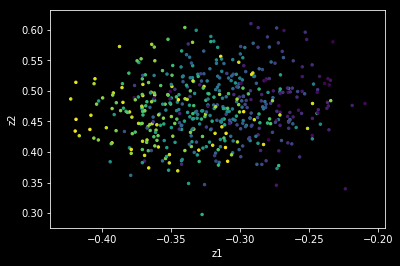

epoch: 4900, M_loss: -6.4, M1_loss: 1.6, M2_loss: -8.0, N_loss: 401.72
epoch: 4900, rec_loss: 0.06424, kl_w: 3.17, kl_z: 12.98


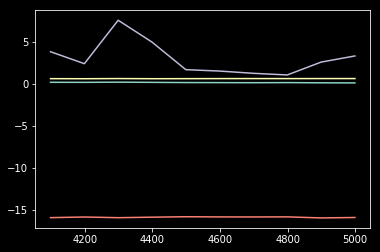

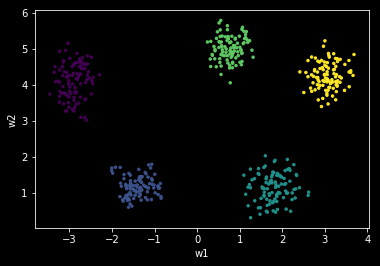

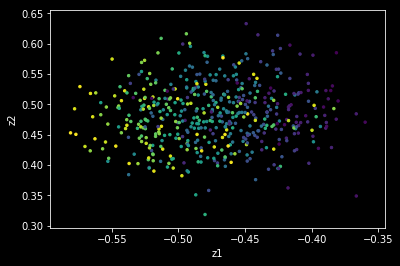

epoch: 5000, M_loss: -6.5, M1_loss: 1.5, M2_loss: -8.0, N_loss: 399.51
epoch: 5000, rec_loss: 0.05820, kl_w: 3.17, kl_z: 16.64


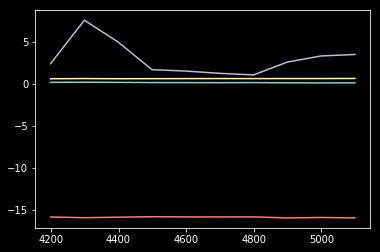

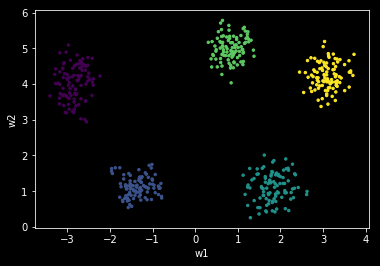

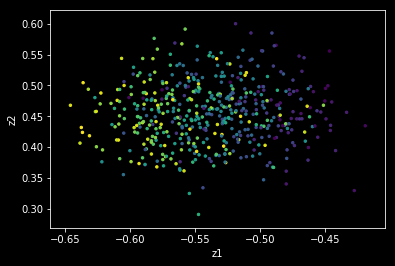

epoch: 5100, M_loss: -6.4, M1_loss: 1.6, M2_loss: -8.0, N_loss: 397.61
epoch: 5100, rec_loss: 0.06218, kl_w: 3.23, kl_z: 17.53


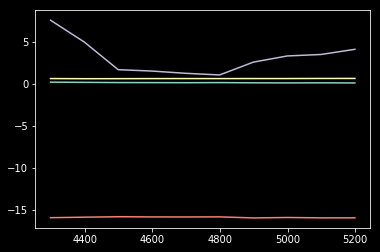

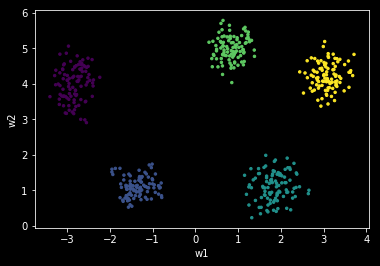

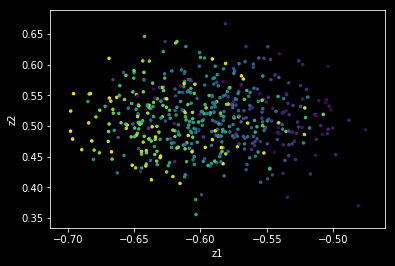

epoch: 5200, M_loss: -6.5, M1_loss: 1.5, M2_loss: -8.0, N_loss: 398.64
epoch: 5200, rec_loss: 0.05619, kl_w: 3.24, kl_z: 20.60


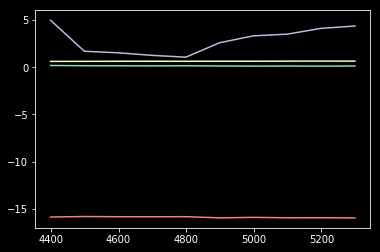

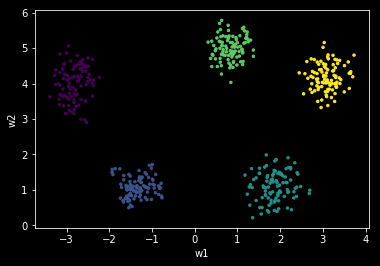

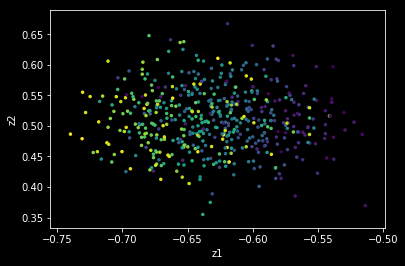

epoch: 5300, M_loss: -6.4, M1_loss: 1.6, M2_loss: -8.0, N_loss: 399.43
epoch: 5300, rec_loss: 0.06368, kl_w: 3.23, kl_z: 21.85


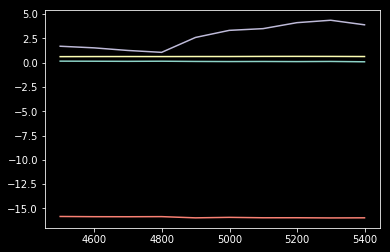

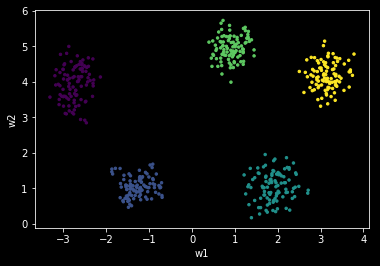

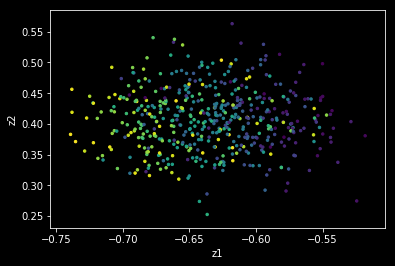

epoch: 5400, M_loss: -6.7, M1_loss: 1.3, M2_loss: -8.0, N_loss: 397.82
epoch: 5400, rec_loss: 0.04633, kl_w: 3.17, kl_z: 19.50


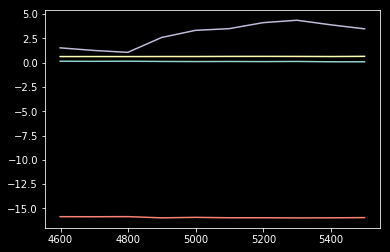

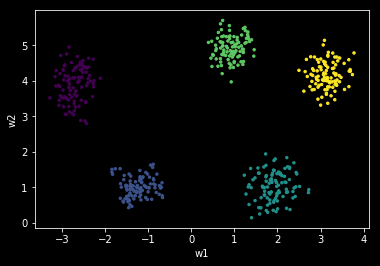

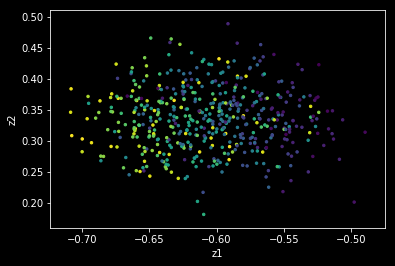

epoch: 5500, M_loss: -6.7, M1_loss: 1.3, M2_loss: -8.0, N_loss: 396.91
epoch: 5500, rec_loss: 0.04583, kl_w: 3.26, kl_z: 17.43


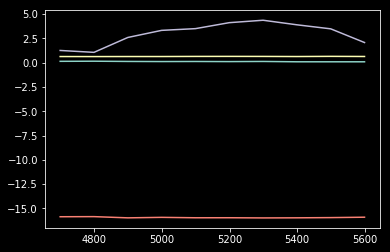

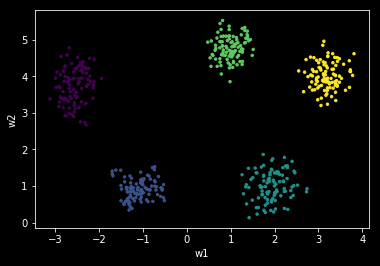

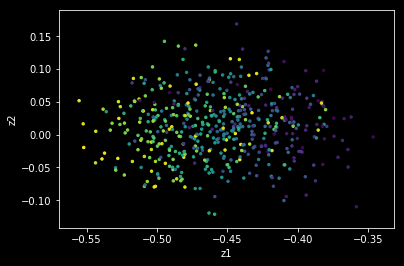

epoch: 5600, M_loss: -6.7, M1_loss: 1.2, M2_loss: -8.0, N_loss: 394.28
epoch: 5600, rec_loss: 0.04595, kl_w: 3.19, kl_z: 10.37


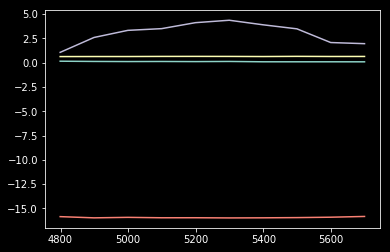

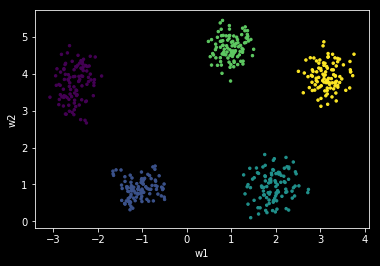

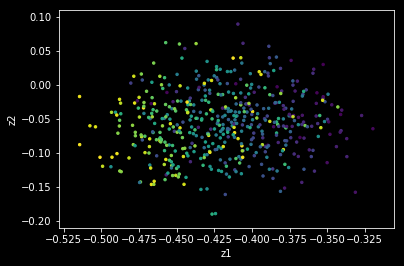

epoch: 5700, M_loss: -6.7, M1_loss: 1.2, M2_loss: -7.9, N_loss: 393.31
epoch: 5700, rec_loss: 0.04479, kl_w: 3.21, kl_z: 9.79


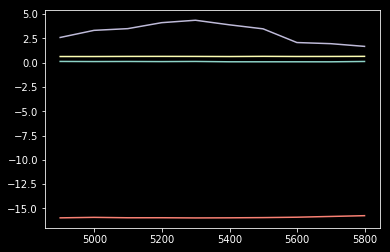

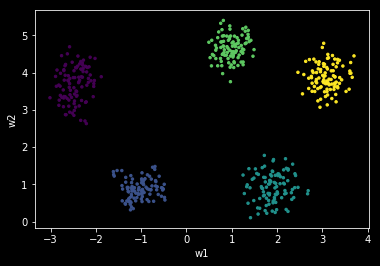

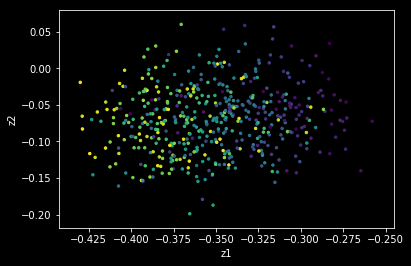

epoch: 5800, M_loss: -6.3, M1_loss: 1.6, M2_loss: -7.9, N_loss: 396.93
epoch: 5800, rec_loss: 0.06264, kl_w: 3.26, kl_z: 8.40


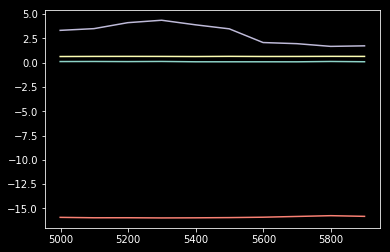

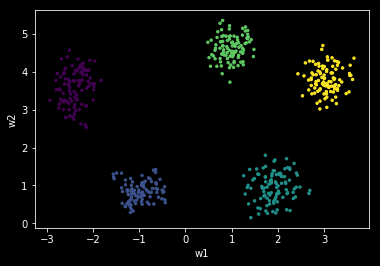

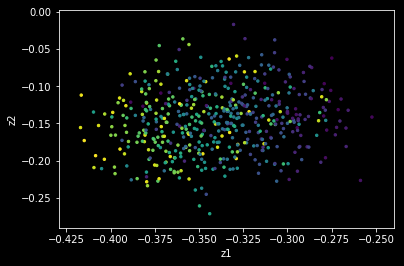

epoch: 5900, M_loss: -6.6, M1_loss: 1.3, M2_loss: -7.9, N_loss: 393.69
epoch: 5900, rec_loss: 0.04842, kl_w: 3.23, kl_z: 8.68


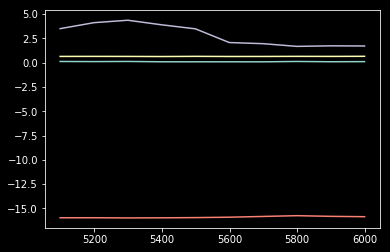

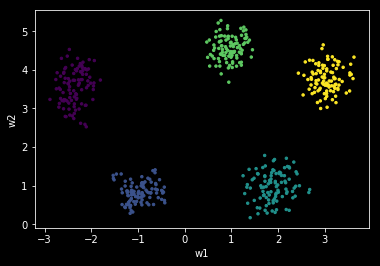

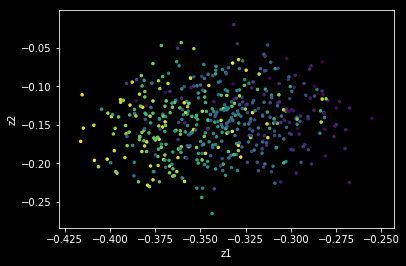

epoch: 6000, M_loss: -6.5, M1_loss: 1.4, M2_loss: -7.9, N_loss: 393.74
epoch: 6000, rec_loss: 0.05494, kl_w: 3.29, kl_z: 8.60


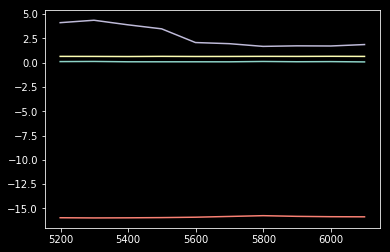

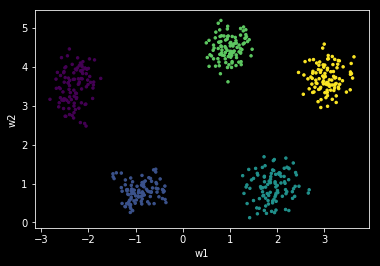

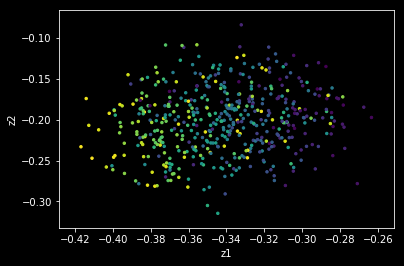

epoch: 6100, M_loss: -6.8, M1_loss: 1.1, M2_loss: -7.9, N_loss: 395.40
epoch: 6100, rec_loss: 0.04018, kl_w: 3.23, kl_z: 9.34


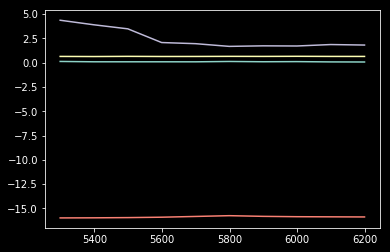

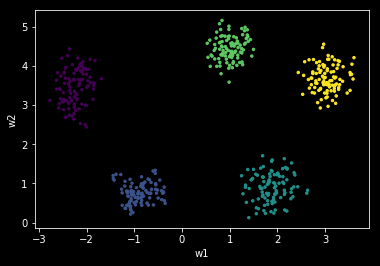

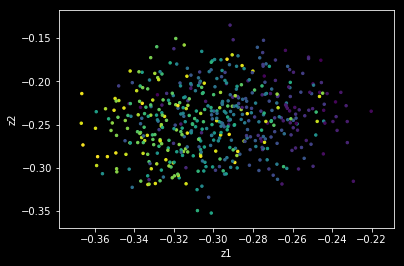

epoch: 6200, M_loss: -6.9, M1_loss: 1.0, M2_loss: -7.9, N_loss: 395.88
epoch: 6200, rec_loss: 0.03590, kl_w: 3.22, kl_z: 9.08


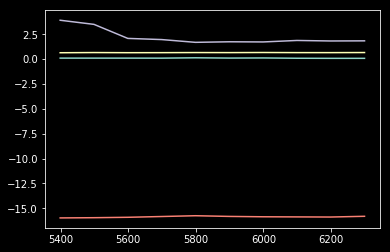

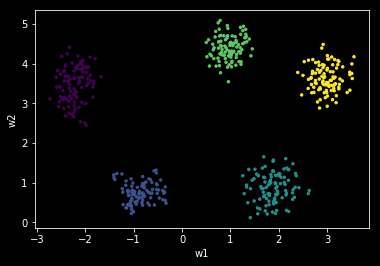

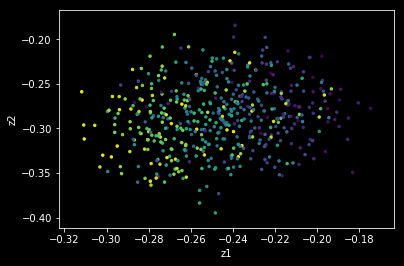

epoch: 6300, M_loss: -6.9, M1_loss: 1.1, M2_loss: -7.9, N_loss: 393.65
epoch: 6300, rec_loss: 0.03585, kl_w: 3.27, kl_z: 9.15


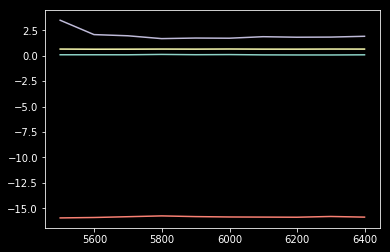

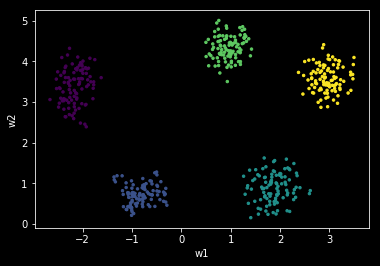

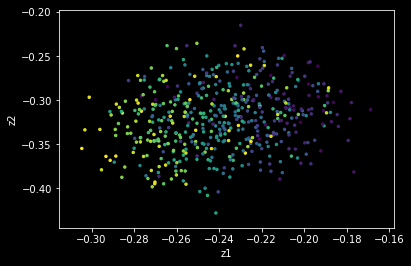

epoch: 6400, M_loss: -6.7, M1_loss: 1.2, M2_loss: -7.9, N_loss: 392.05
epoch: 6400, rec_loss: 0.04335, kl_w: 3.25, kl_z: 9.54


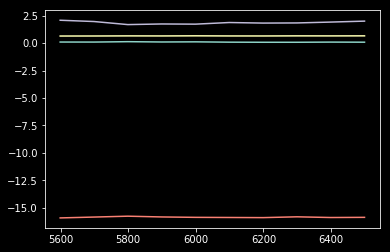

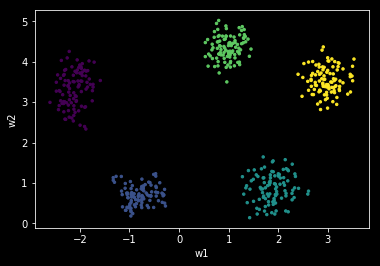

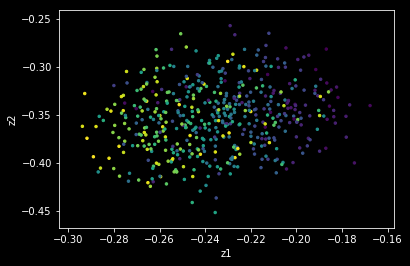

epoch: 6500, M_loss: -6.8, M1_loss: 1.1, M2_loss: -7.9, N_loss: 395.87
epoch: 6500, rec_loss: 0.03923, kl_w: 3.28, kl_z: 9.97


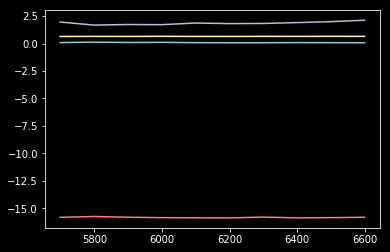

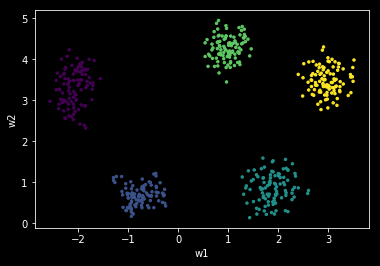

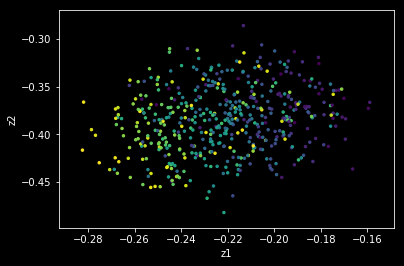

epoch: 6600, M_loss: -6.9, M1_loss: 1.0, M2_loss: -7.9, N_loss: 394.38
epoch: 6600, rec_loss: 0.03467, kl_w: 3.26, kl_z: 10.61


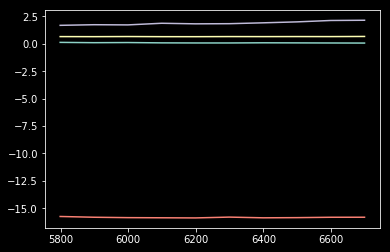

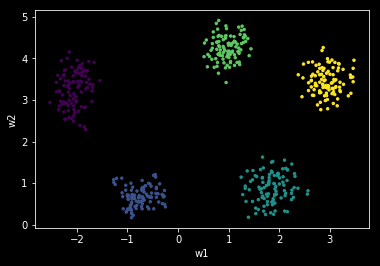

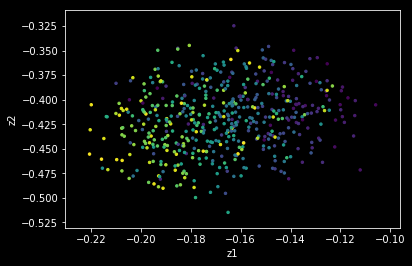

epoch: 6700, M_loss: -6.9, M1_loss: 1.0, M2_loss: -7.9, N_loss: 394.91
epoch: 6700, rec_loss: 0.03108, kl_w: 3.33, kl_z: 10.72


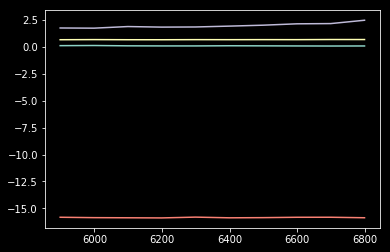

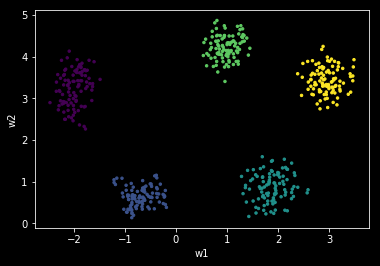

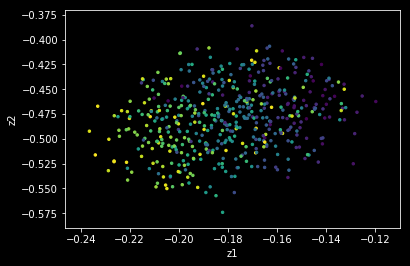

epoch: 6800, M_loss: -6.9, M1_loss: 1.0, M2_loss: -7.9, N_loss: 394.01
epoch: 6800, rec_loss: 0.03397, kl_w: 3.32, kl_z: 12.27


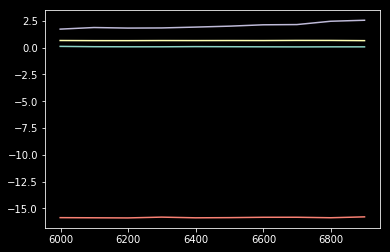

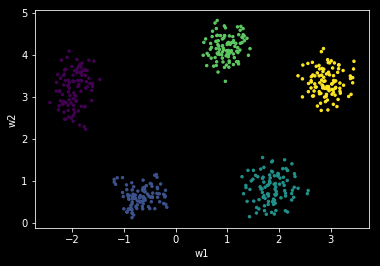

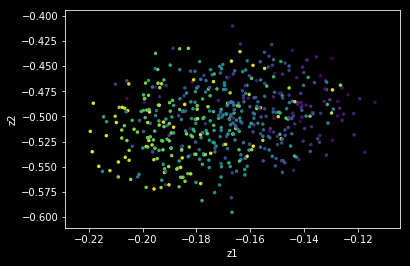

epoch: 6900, M_loss: -6.9, M1_loss: 1.0, M2_loss: -7.9, N_loss: 394.79
epoch: 6900, rec_loss: 0.03299, kl_w: 3.23, kl_z: 12.73


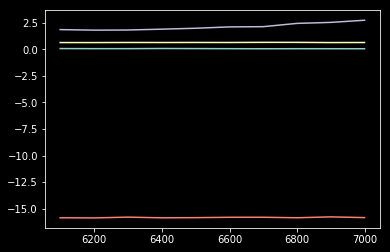

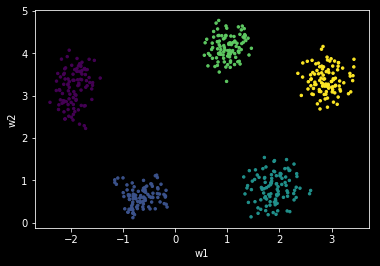

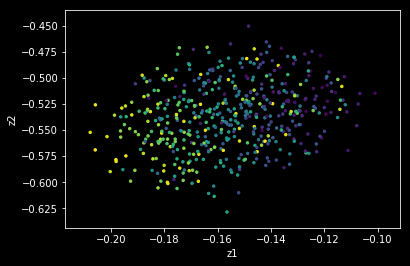

epoch: 7000, M_loss: -7.0, M1_loss: 1.0, M2_loss: -7.9, N_loss: 393.94
epoch: 7000, rec_loss: 0.03168, kl_w: 3.26, kl_z: 13.75


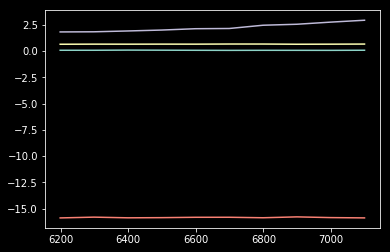

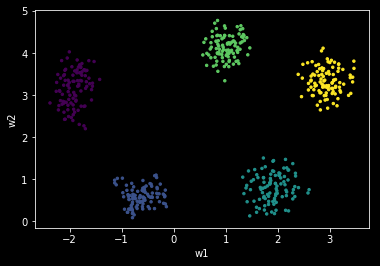

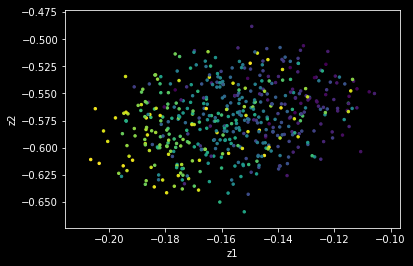

epoch: 7100, M_loss: -6.9, M1_loss: 1.1, M2_loss: -7.9, N_loss: 396.02
epoch: 7100, rec_loss: 0.03713, kl_w: 3.31, kl_z: 14.64


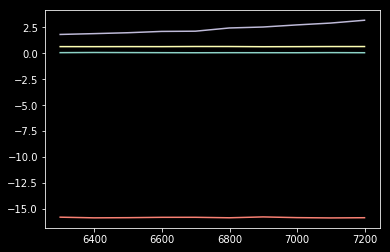

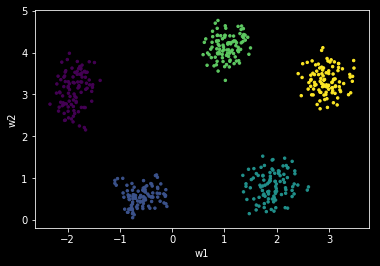

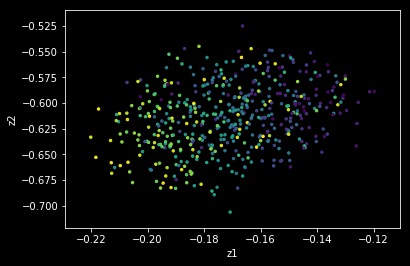

epoch: 7200, M_loss: -6.9, M1_loss: 1.0, M2_loss: -7.9, N_loss: 391.52
epoch: 7200, rec_loss: 0.03237, kl_w: 3.31, kl_z: 16.00


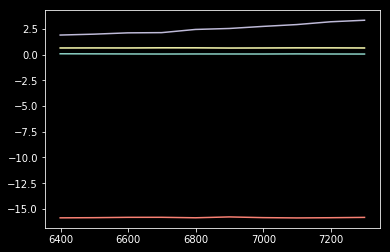

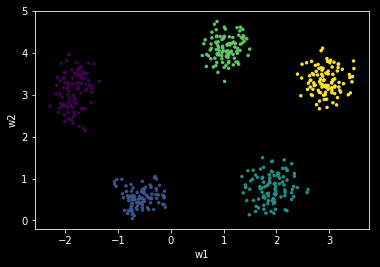

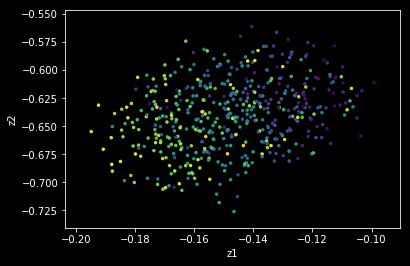

epoch: 7300, M_loss: -7.0, M1_loss: 0.9, M2_loss: -7.9, N_loss: 398.62
epoch: 7300, rec_loss: 0.03013, kl_w: 3.25, kl_z: 16.74


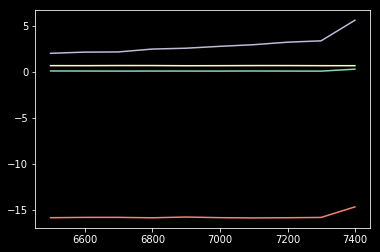

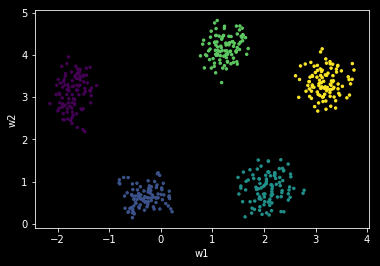

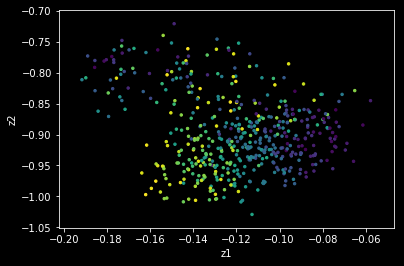

epoch: 7400, M_loss: -4.3, M1_loss: 3.1, M2_loss: -7.3, N_loss: 382.69
epoch: 7400, rec_loss: 0.13595, kl_w: 3.25, kl_z: 27.92


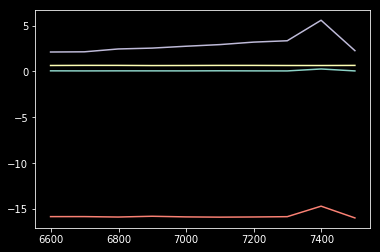

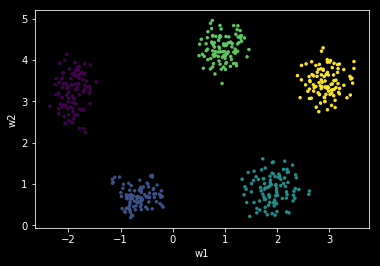

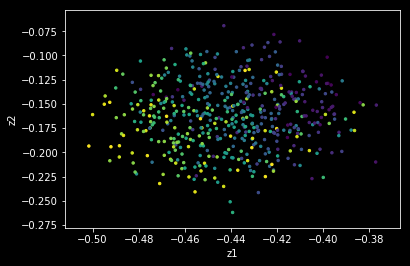

epoch: 7500, M_loss: -7.0, M1_loss: 0.9, M2_loss: -8.0, N_loss: 397.56
epoch: 7500, rec_loss: 0.02999, kl_w: 3.30, kl_z: 11.35


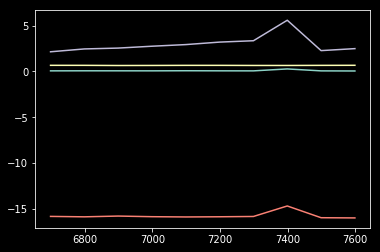

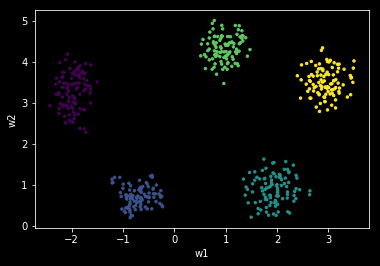

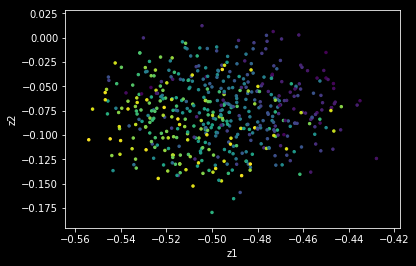

epoch: 7600, M_loss: -7.2, M1_loss: 0.8, M2_loss: -8.0, N_loss: 397.48
epoch: 7600, rec_loss: 0.02412, kl_w: 3.34, kl_z: 12.44


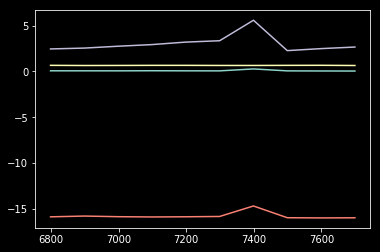

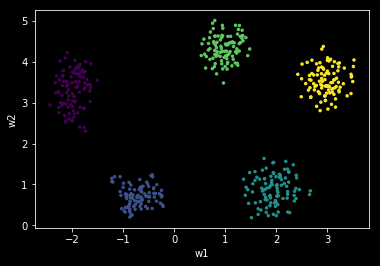

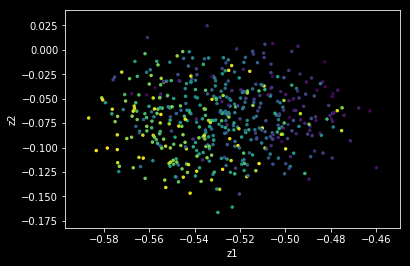

epoch: 7700, M_loss: -7.2, M1_loss: 0.7, M2_loss: -8.0, N_loss: 400.16
epoch: 7700, rec_loss: 0.02057, kl_w: 3.23, kl_z: 13.30


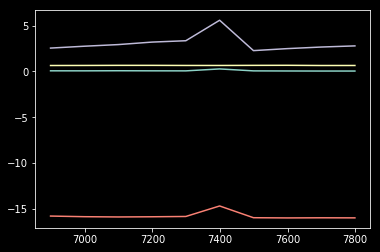

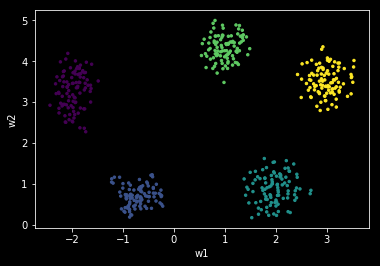

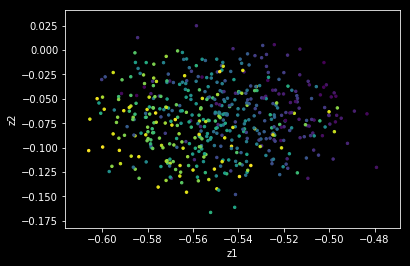

epoch: 7800, M_loss: -7.2, M1_loss: 0.8, M2_loss: -8.0, N_loss: 399.88
epoch: 7800, rec_loss: 0.02072, kl_w: 3.24, kl_z: 13.93


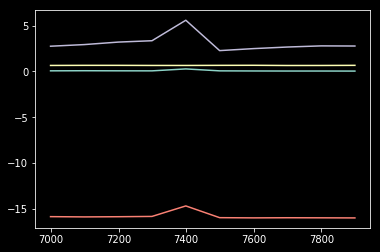

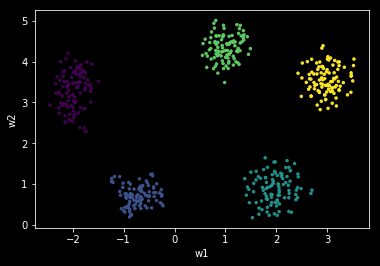

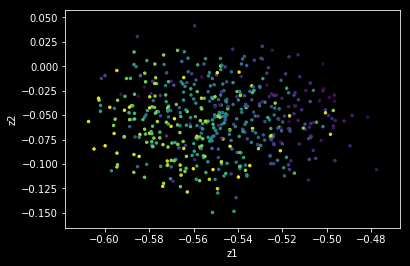

epoch: 7900, M_loss: -7.3, M1_loss: 0.7, M2_loss: -8.0, N_loss: 399.13
epoch: 7900, rec_loss: 0.01785, kl_w: 3.31, kl_z: 13.86


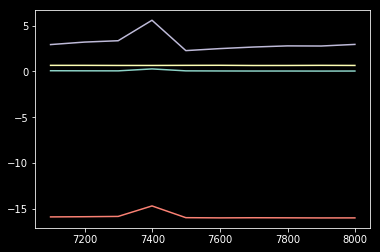

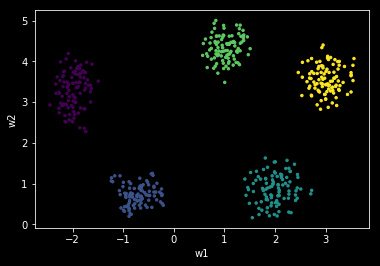

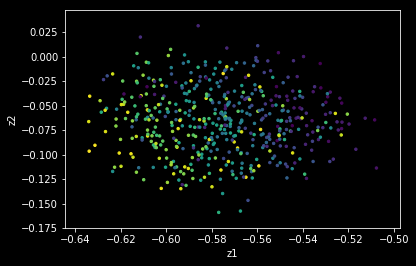

epoch: 8000, M_loss: -7.2, M1_loss: 0.7, M2_loss: -8.0, N_loss: 399.02
epoch: 8000, rec_loss: 0.02048, kl_w: 3.25, kl_z: 14.74


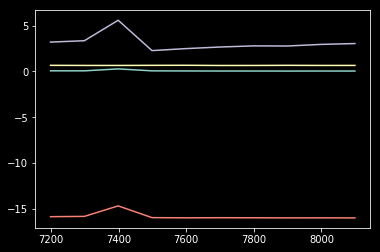

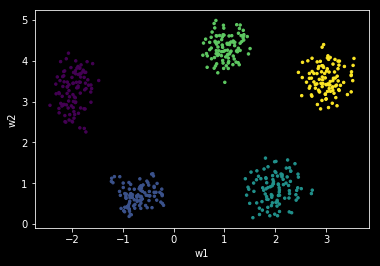

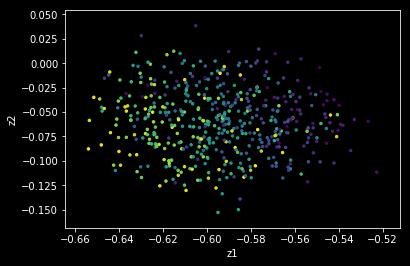

epoch: 8100, M_loss: -7.3, M1_loss: 0.7, M2_loss: -8.0, N_loss: 399.20
epoch: 8100, rec_loss: 0.01953, kl_w: 3.26, kl_z: 15.20


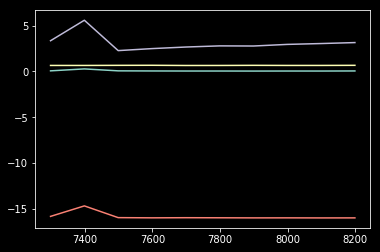

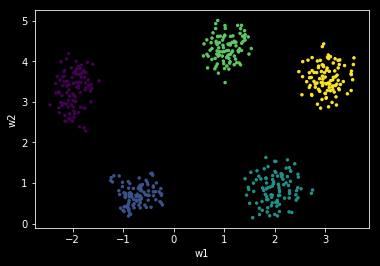

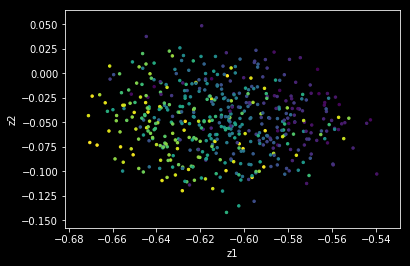

epoch: 8200, M_loss: -7.2, M1_loss: 0.8, M2_loss: -8.0, N_loss: 397.93
epoch: 8200, rec_loss: 0.02462, kl_w: 3.31, kl_z: 15.73


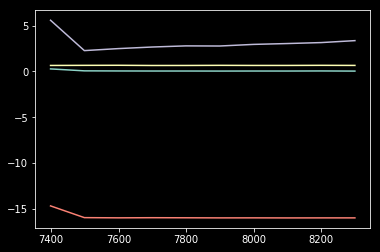

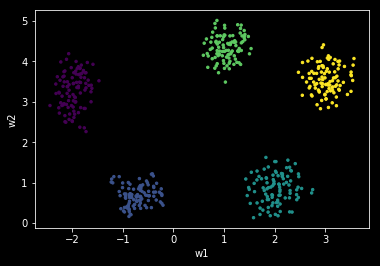

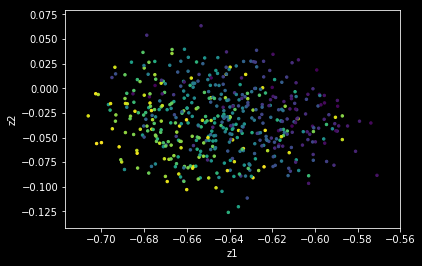

epoch: 8300, M_loss: -7.3, M1_loss: 0.7, M2_loss: -8.0, N_loss: 398.70
epoch: 8300, rec_loss: 0.01675, kl_w: 3.27, kl_z: 16.79


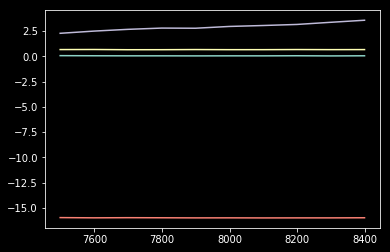

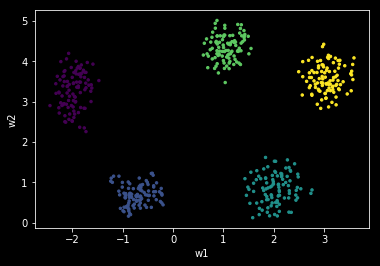

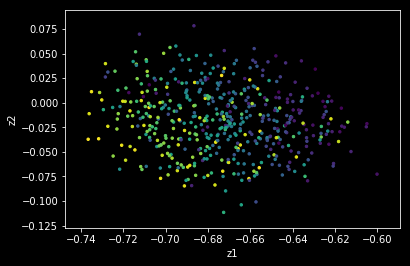

epoch: 8400, M_loss: -7.2, M1_loss: 0.8, M2_loss: -8.0, N_loss: 397.12
epoch: 8400, rec_loss: 0.02277, kl_w: 3.29, kl_z: 17.81


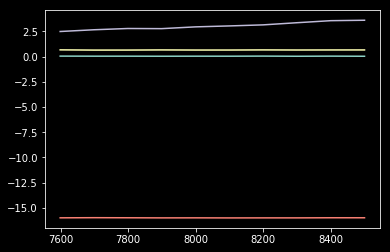

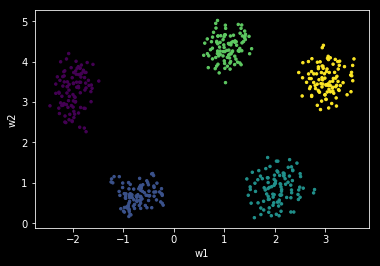

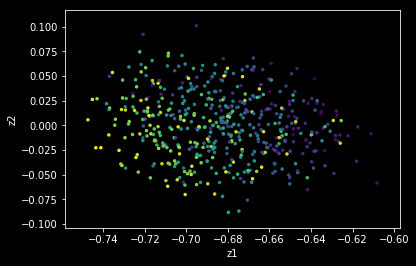

epoch: 8500, M_loss: -7.3, M1_loss: 0.7, M2_loss: -8.0, N_loss: 399.07
epoch: 8500, rec_loss: 0.01706, kl_w: 3.30, kl_z: 18.02


KeyboardInterrupt: ignored

In [110]:
n_epochs = 15000
batch_size = X.shape[0]
start = time.time()
rec_out_plt = []
kl_w_plt= []
kl_z_plt = []
epoch_plt = []
M2_plt = []
N_loss_plt = []
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  
  for i in range(n_epochs):
    gen = batch_generator(X, X, U[:,np.newaxis], batch_size) #create batch generator
    M_loss = 0
    N_loss = 0
    rec_loss_ = 0
    kl_w_ = 0
    kl_z_ = 0
    M1_ = 0
    M2_ = 0
    ent2_ = 0
    logN_ = 0
    
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      
      
      _, M_loss_, rec_loss__, kl_w__, kl_z__, M1__, ent2__, M2__= sess.run([M_train, M_cost, rec_loss, kl_w, kl_z, M1, ent2, M2], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch, training_phase:True})
      M_loss += M_loss_
      rec_loss_ += rec_loss__
      kl_w_ += kl_w__
      kl_z_ += kl_z__
      M1_ += M1__
      M2_ += M2__
      
      _, N_loss_, logN__= sess.run([N_train, N_cost, logN], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch, training_phase:True})
      N_loss += N_loss_
      logN_ += logN__
      
      
    if (i+1)% 100 == 0 or i == 0:
      wIxy_mean_, zIx_mean_, rec_out_= sess.run([wIxy_mean, zIx_mean, rec_out], feed_dict ={x_in:X, x_out:X, u_in:U[:,np.newaxis], training_phase:False})
      rec_out_plt.append(rec_loss_)
      kl_w_plt.append(kl_w_/10.0)
      kl_z_plt.append(kl_z_/10.0)
      M2_plt.append(M2_/1.0)
      N_loss_plt.append(N_loss)
      epoch_plt.append(i)
      
      plt.figure(1) 
      plt.plot(epoch_plt[-10:], rec_out_plt[-10:])
      plt.plot(epoch_plt[-10:], kl_w_plt[-10:])
      plt.plot(epoch_plt[-10:], kl_z_plt[-10:])
      plt.plot(epoch_plt[-10:], M2_plt[-10:])
      
      plt.figure(2)
      plt.scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=U, s=6.0, cmap='viridis');
      plt.xlabel('w1');
      plt.ylabel('w2');
      
      plt.figure(3)
      plt.scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=t, s=6.0, cmap='viridis');
      plt.xlabel('z1');
      plt.ylabel('z2');
      plt.show()
      
      end = time.time()
      print('epoch: {0}, M_loss: {1:.1f}, M1_loss: {2:.1f}, M2_loss: {3:.1f}, N_loss: {4:.2f}'.format((i+1), M_loss/(1+np.int(X.shape[0]/batch_size)), M1_/(1+np.int(X.shape[0]/batch_size)), M2_/(1+np.int(X.shape[0]/batch_size)), N_loss_/(1+np.int(X.shape[0]/batch_size))))
      print('epoch: {0}, rec_loss: {1:.5f}, kl_w: {2:.2f}, kl_z: {3:.2f}'.format((i+1), rec_loss_/(1+np.int(X.shape[0]/batch_size)), kl_w_/(1+np.int(X.shape[0]/batch_size)), kl_z_/(1+np.int(X.shape[0]/batch_size))))
      start = time.time()

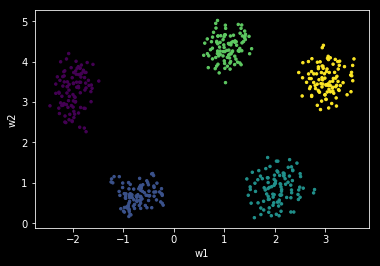

In [111]:
  plt.figure(2)
  plt.scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=U, s=6.0, cmap='viridis');
  plt.xlabel('w1');
  plt.ylabel('w2');

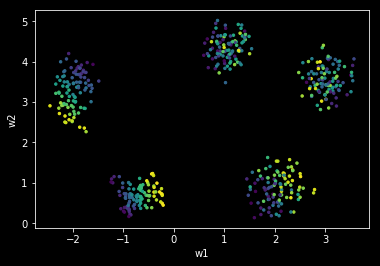

In [113]:
  plt.figure(2)
  plt.scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=t, s=6.0, cmap='viridis');
  plt.xlabel('w1');
  plt.ylabel('w2');

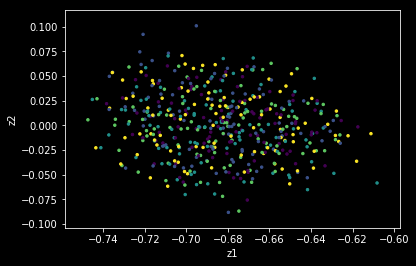

In [114]:
plt.figure(3)
plt.scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U, s=6.0, cmap='viridis');
plt.xlabel('z1');
plt.ylabel('z2');
plt.show()

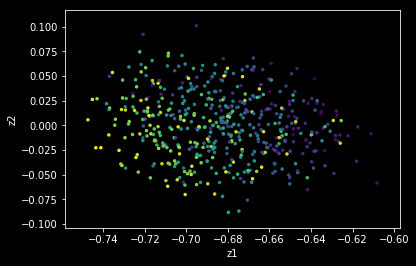

In [115]:
plt.figure(3)
plt.scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=t, s=6.0, cmap='viridis');
plt.xlabel('z1');
plt.ylabel('z2');
plt.show()